In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import mapping, box, Point
from shapely.ops import unary_union
from rasterio.features import geometry_mask
from affine import Affine
import geopandas as gpd
from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor

In [3]:
denton = Preprocessor.load(config_path = "/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/config.json")

In [ ]:
denton_fullmonte_depths = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/1_interim/Denton/denton_fullmonte_depths.pq")

In [4]:
# Transpose and average precip + max over watershed
def sample_one_transposed_precip(
    precip_cube,            # xr.DataArray with dims: (storm_path, y, x)
    storm_centers,          # pd.DataFrame with columns: ['storm_path','x','y']
    watershed_gdf,          # GeoDataFrame in SAME CRS/grid as precip_cube
    x_new: float,
    y_new: float,
    seed: int | None = None,
):
    """
    Randomly pick one storm (storm_path), shift it to (x_new, y_new), truncate wrapped
    edges, mask to watershed, and return:
      - precip_avg_mm: watershed-average precipitation (mm)
      - precip_max_mm: watershed-maximum gridcell precipitation (mm)
      - x_max, y_max: grid coordinates of that max cell
    """
    rng = np.random.default_rng(seed)

    # Grid & transform
    x_coords = precip_cube.coords["x"].values
    y_coords = precip_cube.coords["y"].values
    dx = float(np.mean(np.diff(x_coords)))
    dy = float(np.mean(np.diff(y_coords)))

    transform = (Affine.translation(x_coords[0] - dx/2.0, y_coords[0] - dy/2.0)
                 * Affine.scale(dx, dy))

    # Watershed mask (True inside watershed)
    ws_mask = geometry_mask(
        geometries=[mapping(geom) for geom in watershed_gdf.geometry],
        out_shape=(len(y_coords), len(x_coords)),
        transform=transform,
        invert=True,
    )

    # Pick a random storm
    storm_paths = precip_cube.coords["storm_path"].values
    storm_path = rng.choice(storm_paths)
    storm_idx = int(np.where(storm_paths == storm_path)[0][0])

    # Original center
    centers = storm_centers.set_index("storm_path")
    if storm_path not in centers.index:
        raise ValueError(f"storm_path '{storm_path}' not found in storm_centers.")
    x_orig, y_orig = centers.loc[storm_path, ["x", "y"]]

    # Shift (roll) by whole cells and zero wrapped edges
    dx_cells = int(round((x_new - x_orig) / dx))
    dy_cells = int(round((y_new - y_orig) / dy))

    precip = precip_cube.isel(storm_path=storm_idx).values  # (y, x)
    shifted = np.roll(precip, shift=(dy_cells, dx_cells), axis=(0, 1)).astype(float)

    if dy_cells > 0:
        shifted[:dy_cells, :] = 0
    elif dy_cells < 0:
        shifted[dy_cells:, :] = 0

    if dx_cells > 0:
        shifted[:, :dx_cells] = 0
    elif dx_cells < 0:
        shifted[:, dx_cells:] = 0

    # Replace NaNs with 0 before masking
    shifted = np.where(np.isnan(shifted), 0.0, shifted)

    # Average over watershed
    ws_ncells = int(ws_mask.sum())
    if ws_ncells == 0:
        raise ValueError("Watershed mask is empty; check CRS/grid alignment.")
    masked_sum = float((shifted * ws_mask).sum())
    precip_avg_mm = masked_sum / ws_ncells

    # Max over watershed (and its location)
    # Use -inf outside watershed so argmax ignores non-watershed cells
    masked_for_max = np.where(ws_mask, shifted, -np.inf)
    iy, ix = np.unravel_index(np.nanargmax(masked_for_max), masked_for_max.shape)
    precip_max_mm = float(masked_for_max[iy, ix])

    return {
        "storm_path": str(storm_path),
        "x_orig": float(x_orig), "y_orig": float(y_orig),
        "dx_cells": int(dx_cells), "dy_cells": int(dy_cells),
        "precip_avg_mm": float(precip_avg_mm),
        "precip_max_mm": float(precip_max_mm),
    }

In [5]:
#Domain area and bounding box
np.random.seed(42)
domain_gdf = denton.domain_gdf.copy()
domain_gdf = domain_gdf.explode(index_parts=False).reset_index(drop=True)
domain_geom = unary_union(domain_gdf.geometry.values)
assert domain_geom.is_valid

xmin, ymin, xmax, ymax = domain_geom.bounds
bbox_geom = box(xmin, ymin, xmax, ymax)

A_domain = domain_geom.area
A_bbox   = bbox_geom.area

A_domain, A_bbox

(919751892774.4385, 1726372206862.3167)

In [6]:
# Total budget split into iterations
N_total = 4000
T = 10
B = N_total // T   # batch per iteration

# Split controls
n_min_to_split = 10          # min samples in a leaf before it can be split
max_depth = 20               # safety cap
min_leaf_area_frac = 1e-5    # don't keep children with negligible area
eps_var = 1e-12              # tiny epsilon in scores

In [7]:
# --- Initial grid of leaves
nx0, ny0 = 15, 10
dx0 = (xmax - xmin) / nx0
dy0 = (ymax - ymin) / ny0

rows = []
leaf_id = 0
for i in range(nx0):
    for j in range(ny0):
        x0 = xmin + i * dx0
        x1 = xmin + (i + 1) * dx0
        y0 = ymin + j * dy0
        y1 = ymin + (j + 1) * dy0
        b = box(x0, y0, x1, y1)
        a_in = b.intersection(domain_geom).area
        if a_in > 0:  # keep only bins that intersect the polygon
            rows.append({
                "leaf_id": leaf_id,
                "x_min": x0, "x_max": x1, "y_min": y0, "y_max": y1,
                "area_in_domain": a_in,
                "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                "depth": 0, "active": True, "alloc": 0
            })
            leaf_id += 1

leaves = pd.DataFrame(rows).reset_index(drop=True)
print(f"Initial active leaves: {len(leaves)} (from {nx0*ny0} bins)")
leaves.head()

Initial active leaves: 104 (from 150 bins)


,leaf_id,x_min,x_max,y_min,y_max,area_in_domain,n,mean,m2,var,depth,active,alloc
0,0,-315046.535275,-203221.839056,415548.678398,518470.022563,8.807680e+07,0,0.0,0.0,NaN,0,True,0
1,1,-315046.535275,-203221.839056,518470.022563,621391.366728,1.931821e+09,0,0.0,0.0,NaN,0,True,0
2,2,-315046.535275,-203221.839056,621391.366728,724312.710893,9.551131e+09,0,0.0,0.0,NaN,0,True,0
3,3,-315046.535275,-203221.839056,724312.710893,827234.055058,8.127701e+09,0,0.0,0.0,NaN,0,True,0
4,4,-315046.535275,-203221.839056,827234.055058,930155.399223,7.922862e+09,0,0.0,0.0,NaN,0,True,0


In [ ]:
samples = pd.DataFrame(columns=["iter","leaf_id","x","y","g"])
samples

In [ ]:
#Step 1
t = 1
act_idx = leaves.index[leaves["active"]].to_list()
if len(act_idx) == 0:
    raise RuntimeError("No active leaves to allocate to.")

# 1) Build tempered, blended scores
eps = float(eps_var)

area = leaves.loc[act_idx, "area_in_domain"].astype(float)
var  = leaves.loc[act_idx, "var"].fillna(0.0).clip(lower=0.0)

# Blend between area-only and (Neyman) std×area, then temper to flatten extremes
lam   = 0.6   # 0 = pure area, 1 = pure Neyman
alpha = 0.7   # 0<alpha<=1; smaller -> flatter

score_neyman = np.sqrt(var + eps) * area       # ∝ σ_j * A_j
score_area   = area.copy()
scores_raw   = lam * score_neyman + (1 - lam) * score_area
scores       = np.power(scores_raw, alpha)

# Fallback if first iter has no data
if (leaves.loc[act_idx, "n"] <= 0).all() or scores.sum() <= 0:
    scores = area.copy()

# 2) Baseline floor: 1 per active leaf only if feasible
alloc = pd.Series(0, index=act_idx, dtype=int)
if B >= len(act_idx):
    alloc += 1
    B_rem = B - len(act_idx)
else:
    B_rem = B  # no floor if budget is too small

# 3) Proportional + fractional rounding for the remainder
weights     = scores / scores.sum()
alloc_float = B_rem * weights

alloc += np.floor(alloc_float).astype(int)
R = B - int(alloc.sum())

if R > 0:
    # give extra units to largest fractional parts (fair rounding)
    frac = (alloc_float - np.floor(alloc_float)).sort_values(ascending=False)
    alloc.loc[frac.index[:R]] += 1

# 4) Soft per-leaf cap (optional): prevent one cell from taking too much
cap_frac = 0.05             # e.g., ≤5% of B per leaf
cap_min  = 6                # but allow at least this many if warranted
cap = max(int(np.ceil(cap_frac * B)), cap_min)

over = alloc - np.minimum(alloc, cap)
extra = int(over[over > 0].sum())
if extra > 0:
    # clip to cap, then re-distribute the overage to under-cap leaves by weights
    alloc[alloc > cap] = cap
    under = alloc.index[alloc < cap]
    if len(under) > 0:
        w_under = (weights.loc[under] / weights.loc[under].sum()).fillna(0.0)
        add_float = extra * w_under
        alloc.loc[under] += np.floor(add_float).astype(int)
        R2 = B - int(alloc.sum())
        if R2 > 0:
            frac2 = (add_float - np.floor(add_float)).sort_values(ascending=False)
            alloc.loc[frac2.index[:R2]] += 1

# 5) Write back
leaves.loc[:, "alloc"] = 0
leaves.loc[alloc.index, "alloc"] = alloc.values

print("Active leaves:", len(act_idx))
print("Planned total alloc (active):", int(leaves.loc[leaves["active"], "alloc"].sum()))
print("Planned total alloc (all):   ", int(leaves["alloc"].sum()))
display(leaves.loc[leaves["active"], ["leaf_id","alloc","n","var","area_in_domain"]]
        .sort_values("alloc", ascending=False).head(2))

In [ ]:
#Step 2
new_rows = []
for _, row in leaves[leaves["active"]].iterrows():
    K = int(row["alloc"])
    if K <= 0:
        continue

    x0, x1 = row["x_min"], row["x_max"]
    y0, y1 = row["y_min"], row["y_max"]

    # clip the leaf to the domain to improve acceptance
    leaf_clip = box(x0, y0, x1, y1).intersection(domain_geom)
    if leaf_clip.is_empty:
        continue

    kept, attempts = 0, 0
    xs, ys = [], []

    # be generous on attempts for skinny boundary cells
    max_attempts = max(K * 200, 5000)

    while kept < K and attempts < max_attempts:
        attempts += 1
        xr = np.random.uniform(x0, x1)
        yr = np.random.uniform(y0, y1)
        # covers -> accept boundary too; more robust than contains
        if leaf_clip.covers(Point(xr, yr)):
            xs.append(xr); ys.append(yr)
            kept += 1

    if kept < K:
        print(f"[iter {t}] WARN leaf {int(row['leaf_id'])}: planned={K}, kept={kept}, attempts={attempts}")

    # append ONLY what you actually kept (prevents IndexError)
    for x, y in zip(xs, ys):
        new_rows.append({"iter": t, "leaf_id": row["leaf_id"], "x": x, "y": y, "g": np.nan})

print("rows built:", len(new_rows), " planned B:", int(leaves.loc[leaves["active"], "alloc"].sum()))

In [ ]:
#Step 3
new_df = pd.DataFrame(new_rows).reset_index(drop=True)

# Compute watershed-avg precip for each sample by randomly picking a storm and transposing
g_vals = np.empty(len(new_df), dtype=float)
storm_used = np.empty(len(new_df), dtype=object)
dx_cells_used = np.empty(len(new_df), dtype=int)
dy_cells_used = np.empty(len(new_df), dtype=int)
x_orig_used = np.empty(len(new_df), dtype=float)
y_orig_used = np.empty(len(new_df), dtype=float)
max_p = np.empty(len(new_df), dtype=float)

for i in new_df.index:
    x_new = float(new_df.at[i, "x"])
    y_new = float(new_df.at[i, "y"])

    out = sample_one_transposed_precip(
        precip_cube=denton.cumulative_precip,
        storm_centers=denton.storm_centers,
        watershed_gdf=denton.watershed_gdf,
        x_new=x_new,
        y_new=y_new,
        seed=None,          # or set an int for reproducibility
    )

    g_vals[i]         = out["precip_avg_mm"]
    storm_used[i]     = out["storm_path"]
    dx_cells_used[i]  = out["dx_cells"]
    dy_cells_used[i]  = out["dy_cells"]
    x_orig_used[i]    = out["x_orig"]
    y_orig_used[i]    = out["y_orig"]
    max_p[i]          = out["precip_max_mm"]

# Attach results
new_df["g"] = g_vals
new_df["storm_path"] = storm_used
new_df["dx_cells"] = dx_cells_used
new_df["dy_cells"] = dy_cells_used
new_df["x_orig"] = x_orig_used
new_df["y_orig"] = y_orig_used
new_df["max_p"]  = max_p 

# Append to the running samples table
samples = pd.concat([samples, new_df], ignore_index=True)

new_df.head()

In [ ]:
#Step 4
# Update each active leaf with its new samples (Welford's online algorithm)
for leaf_id in leaves.loc[leaves["active"], "leaf_id"].tolist():
    sel = new_df["leaf_id"] == leaf_id
    vals = new_df.loc[sel, "g"].to_numpy()
    if vals.size == 0:
        continue

    j = leaves.index[leaves["leaf_id"] == leaf_id][0]
    n = int(leaves.at[j, "n"])
    mean = float(leaves.at[j, "mean"])
    m2 = float(leaves.at[j, "m2"])

    for v in vals:
        n += 1
        delta = v - mean
        mean += delta / n
        m2 += delta * (v - mean)

    leaves.at[j, "n"] = n
    leaves.at[j, "mean"] = mean
    leaves.at[j, "m2"] = m2
    leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

leaves[["leaf_id","n","mean","var","area_in_domain","depth","active"]]

In [ ]:
# --- Step 6: Split multiple leaves this iteration (quad-split: both x and y) ---

K_split = 10  # how many parents to split per iteration

# 1) Eligible candidates
candidates = leaves[
    (leaves["active"]) &
    (leaves["n"] >= n_min_to_split) &
    (leaves["depth"] < max_depth)
].copy()

# 2) Score = variance × area (same as before)
candidates["score"] = candidates["var"].fillna(0.0) * candidates["area_in_domain"]

# 3) Pick top-K by score (>0)
candidates = candidates[candidates["score"] > 0]
to_split_idx = candidates.sort_values("score", ascending=False).index[:K_split]

new_rows = []
parents_to_deactivate = []
next_id = int(leaves["leaf_id"].max()) + 1

# 4) Quad-split each selected parent
for j in to_split_idx:
    leaf = leaves.loc[j].copy()
    xL, xU = float(leaf["x_min"]), float(leaf["x_max"])
    yL, yU = float(leaf["y_min"]), float(leaf["y_max"])

    # skip degenerate
    if (xU - xL) <= 0 or (yU - yL) <= 0:
        continue

    x_mid = 0.5 * (xL + xU)
    y_mid = 0.5 * (yL + yU)

    child_boxes = [
        box(xL,    yL,    x_mid, y_mid),  # SW
        box(x_mid, yL,    xU,    y_mid),  # SE
        box(xL,    y_mid, x_mid, yU),     # NW
        box(x_mid, y_mid, xU,    yU),     # NE
    ]

    made_children = 0
    for b in child_boxes:
        a_in = b.intersection(domain_geom).area
        if a_in >= (min_leaf_area_frac * A_domain):
            new_rows.append({
                "leaf_id": next_id,
                "x_min": b.bounds[0], "x_max": b.bounds[2],
                "y_min": b.bounds[1], "y_max": b.bounds[3],
                "area_in_domain": a_in,
                "n": 0, "mean": 0.0, "m2": 0.0, "var": np.nan,
                "depth": int(leaf["depth"]) + 1,
                "active": True, "alloc": 0
            })
            next_id += 1
            made_children += 1

    # Deactivate parent only if children were created
    if made_children > 0:
        parents_to_deactivate.append(j)

# 5) Apply updates
if parents_to_deactivate:
    leaves.loc[parents_to_deactivate, "active"] = False
    leaves.loc[parents_to_deactivate, "alloc"]  = 0

if new_rows:
    leaves = pd.concat([leaves, pd.DataFrame(new_rows)], ignore_index=True)

print(f"[iter {t}] quad-split {len(parents_to_deactivate)} parents → added {len(new_rows)} children (K_split={K_split})")
# Optional quick view
leaves.sort_values(["active", "depth", "leaf_id"])

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import box, Point
from shapely.ops import unary_union
from affine import Affine
from rasterio.features import geometry_mask
from typing import List, Optional, Tuple


class AdaptiveStratifiedSampler:
    """
    Adaptive stratified (MISER-like) sampler with importance weights to a uniform target.

    Parameters
    ----------
    data : object
        Container with:
          - cumulative_precip : xr.DataArray with dims (storm_path, y, x) and coords x, y, storm_path
          - storm_centers     : pd.DataFrame with cols ['storm_path','x','y'] (same CRS/units as cube)
          - domain_gdf        : GeoDataFrame, polygon(s) of the sampling domain
          - watershed_gdf     : GeoDataFrame, watershed polygon(s) (same CRS/grid as cube)
    nx0, ny0 : int
        Initial grid resolution (columns × rows).
    B : int
        Samples per iteration (budget).
    eps_var : float
        Small constant added to per-leaf variance in the allocation score (stability).
    n_min_to_split : int
        Minimum per-leaf sample count before a leaf becomes eligible to split.
    max_depth : int
        Maximum split depth (root=0).
    min_leaf_area_frac : float
        Minimum child in-domain area as a fraction of domain area; children below this are discarded.
    K_split : int
        Number of parents to split per iteration (quad-split each).
    temper_alpha : float in (0,1]
        Score tempering exponent: scores := scores**alpha (alpha<1 flattens extremes).
    floor_min1 : bool
        If True and B >= #active, give each active leaf ≥ 1 planned sample.

    Attributes
    ----------
    leaves : pd.DataFrame
        Current leaf table with bounds, stats, active flag, etc.
    samples : pd.DataFrame
        All samples drawn so far with columns:
          ['sample_id','iter','leaf_id','x','y','storm_path','g','w_uniform']
    grids_by_iter : List[gpd.GeoDataFrame]
        Grid snapshots (one per iteration) ready to plot the evolution later.

    Notes
    -----
    Target density is uniform over the domain: p(s) = 1 / A_domain.
    Proposal per iteration t is a piecewise-uniform mixture:
        q_t(s) = sum_j a_{j,t} * 1{ s in leaf j } / A_j,
    where a_{j,t} is the realized fraction of kept samples in leaf j at iteration t.
    Importance weight for any sample from leaf j at iteration t:
        w = A_j / (A_domain * a_{j,t}).
    """

    def __init__(self,
                 data,
                 nx0: int = 10,
                 ny0: int = 10,
                 B: int = 500,
                 eps_var: float = 1e-6,
                 n_min_to_split: int = 3,
                 max_depth: int = 10,
                 min_leaf_area_frac: float = 1e-5,
                 K_split: int = 5,
                 temper_alpha: float = 0.8,
                 floor_min1: bool = True):
        self.data = data
        self.cube: xr.DataArray = data.cumulative_precip
        self.centers: pd.DataFrame = data.storm_centers.set_index("storm_path")
        self.domain_gdf: gpd.GeoDataFrame = data.domain_gdf
        self.watershed_gdf: gpd.GeoDataFrame = data.watershed_gdf

        # Domain geometry & area
        self.domain_geom = unary_union(self.domain_gdf.geometry)
        self.A_domain = float(self.domain_geom.area)

        # Grid metadata (for shifting storms and watershed masking)
        x = self.cube.coords["x"].values
        y = self.cube.coords["y"].values
        self.dx = float(np.mean(np.diff(x)))
        self.dy = float(np.mean(np.diff(y)))
        self.transform = Affine.translation(x[0] - self.dx/2.0, y[0] - self.dy/2.0) * Affine.scale(self.dx, self.dy)
        self.ws_mask = geometry_mask(
            geometries=[geom.__geo_interface__ for geom in self.watershed_gdf.geometry],
            out_shape=(len(y), len(x)),
            transform=self.transform,
            invert=True,
        )
        self.x_coords = x
        self.y_coords = y
        self.storm_paths = self.cube.coords["storm_path"].values

        # Controls
        self.nx0, self.ny0 = nx0, ny0
        self.B = int(B)
        self.eps_var = float(eps_var)
        self.n_min_to_split = int(n_min_to_split)
        self.max_depth = int(max_depth)
        self.min_leaf_area_frac = float(min_leaf_area_frac)
        self.K_split = int(K_split)
        self.temper_alpha = float(temper_alpha)
        self.floor_min1 = bool(floor_min1)

        # State
        self.t = 0
        self.samples = pd.DataFrame(columns=["sample_id","iter","leaf_id","x","y","storm_path","g","w_uniform"])
        self._next_sample_id = 0
        self.grids_by_iter: List[gpd.GeoDataFrame] = []

        # Build initial grid of leaves (active=True)
        self.leaves = self._make_initial_grid()

    # ---------- public API ----------

    def run(self, n_iters: int, rng: Optional[np.random.Generator] = None) -> Tuple[pd.DataFrame, List[gpd.GeoDataFrame]]:
        """Run n_iters iterations; return (samples, grids_by_iter)."""
        rng = rng or np.random.default_rng()
        for _ in range(n_iters):
            self.step(rng=rng)
        return self.samples.copy(), list(self.grids_by_iter)

    def step(self, rng: Optional[np.random.Generator] = None) -> None:
        """One MISER-like iteration: allocate → sample → evaluate → update → split → snapshot."""
        rng = rng or np.random.default_rng()
        self.t += 1

        # 1) Allocate to active leaves
        alloc = self._allocate_active()

        # 2) Sample uniformly (leaf ∩ domain), plan vs kept shortfalls allowed
        new_pts = self._sample_points(alloc, rng)

        # 3) Evaluate g (watershed-avg precip) via random storm transposition
        if not new_pts.empty:
            g_vals, storm_used = self._evaluate_g(new_pts, rng)
            new_pts["g"] = g_vals
            new_pts["storm_path"] = storm_used
        else:
            new_pts["g"] = []
            new_pts["storm_path"] = []

        # 4) Per-iteration mixture weight a_{j,t} and importance weights to uniform target
        if not new_pts.empty:
            kept_per_leaf = new_pts.groupby("leaf_id").size().rename("kept").reset_index()
            kept_per_leaf["a_jt"] = kept_per_leaf["kept"] / len(new_pts)
            kept_per_leaf = kept_per_leaf.merge(self.leaves[["leaf_id","area_in_domain"]], on="leaf_id", how="left")
            kept_per_leaf["w_uniform"] = kept_per_leaf["area_in_domain"] / (self.A_domain * kept_per_leaf["a_jt"])
            new_pts = new_pts.merge(kept_per_leaf[["leaf_id","w_uniform"]], on="leaf_id", how="left")
        else:
            new_pts["w_uniform"] = []

        # 5) Append to samples and update leaf Welford stats
        if not new_pts.empty:
            self.samples = pd.concat([self.samples, new_pts], ignore_index=True)
            self._update_leaf_stats(new_pts)

        # 6) Split top-K parents (quad split)
        self._split_topK()

        # 7) Save a plotting snapshot of the grid
        self._snapshot_grid()

    # ---------- internal helpers ----------

    def _make_initial_grid(self) -> pd.DataFrame:
        xmin, ymin, xmax, ymax = self.domain_geom.bounds
        dx0 = (xmax - xmin) / self.nx0
        dy0 = (ymax - ymin) / self.ny0
        rows = []
        leaf_id = 0
        for i in range(self.nx0):
            for j in range(self.ny0):
                b = box(xmin + i*dx0, ymin + j*dy0, xmin + (i+1)*dx0, ymin + (j+1)*dy0)
                a_in = b.intersection(self.domain_geom).area
                if a_in > 0:
                    rows.append(dict(
                        leaf_id=leaf_id,
                        x_min=b.bounds[0], x_max=b.bounds[2],
                        y_min=b.bounds[1], y_max=b.bounds[3],
                        area_in_domain=a_in,
                        n=0, mean=0.0, m2=0.0, var=np.nan,
                        depth=0, active=True, alloc=0
                    ))
                    leaf_id += 1
        return pd.DataFrame(rows)

    def _allocate_active(self) -> pd.Series:
        act = self.leaves.index[self.leaves["active"]].to_list()
        if not act:
            raise RuntimeError("No active leaves to allocate to.")
        area = self.leaves.loc[act, "area_in_domain"].astype(float)
        var = self.leaves.loc[act, "var"].fillna(0.0).clip(lower=0.0)
        scores = (var + self.eps_var) * area
        # first-iter fallback
        if (self.leaves.loc[act, "n"] <= 0).all() or scores.sum() <= 0:
            scores = area.copy()
        # temper to avoid one leaf dominating
        if self.temper_alpha < 1.0:
            scores = np.power(scores, self.temper_alpha)

        alloc = pd.Series(0, index=act, dtype=int)
        B = self.B
        if self.floor_min1 and B >= len(act):
            alloc += 1
            B -= len(act)

        weights = scores / scores.sum()
        alloc_float = B * weights
        alloc += np.floor(alloc_float).astype(int)
        R = self.B - int(alloc.sum())
        if R > 0:
            frac = (alloc_float - np.floor(alloc_float)).sort_values(ascending=False)
            alloc.loc[frac.index[:R]] += 1

        self.leaves.loc[:, "alloc"] = 0
        self.leaves.loc[alloc.index, "alloc"] = alloc.values
        return alloc

    def _sample_points(self, alloc: pd.Series, rng: np.random.Generator) -> pd.DataFrame:
        rows = []
        for idx, r in self.leaves[self.leaves["active"]].iterrows():
            K = int(r["alloc"])
            if K <= 0:
                continue
            x0, x1, y0, y1 = r["x_min"], r["x_max"], r["y_min"], r["y_max"]
            leaf_clip = box(x0, y0, x1, y1).intersection(self.domain_geom)
            if leaf_clip.is_empty:
                continue
            kept = 0
            attempts = 0
            max_attempts = max(K * 200, 5000)
            while kept < K and attempts < max_attempts:
                attempts += 1
                xr = rng.uniform(x0, x1)
                yr = rng.uniform(y0, y1)
                if leaf_clip.covers(Point(xr, yr)):  # includes boundary
                    rows.append(dict(
                        sample_id=self._next_sample_id,
                        iter=self.t,
                        leaf_id=int(r["leaf_id"]),
                        x=float(xr), y=float(yr),
                        storm_path="", g=np.nan, w_uniform=np.nan
                    ))
                    self._next_sample_id += 1
                    kept += 1
        return pd.DataFrame(rows)

    def _evaluate_g(self, pts: pd.DataFrame, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
        # vectorized over rows (loop in Python but precomputed masks)
        g_vals = np.empty(len(pts), dtype=float)
        storm_used = np.empty(len(pts), dtype=object)
        for i, (_, row) in enumerate(pts.iterrows()):
            # random storm
            sp = rng.choice(self.storm_paths)
            sidx = int(np.where(self.storm_paths == sp)[0][0])
            # original center
            x_orig, y_orig = self.centers.loc[sp, ["x","y"]]
            # shift to new (x,y) in cell units
            dx_cells = int(round((row["x"] - x_orig) / self.dx))
            dy_cells = int(round((row["y"] - y_orig) / self.dy))
            # roll and zero wrap
            arr = self.cube.isel(storm_path=sidx).values.astype(float)
            shifted = np.roll(arr, shift=(dy_cells, dx_cells), axis=(0,1))
            if dy_cells > 0: shifted[:dy_cells, :] = 0
            elif dy_cells < 0: shifted[dy_cells:, :] = 0
            if dx_cells > 0: shifted[:, :dx_cells] = 0
            elif dx_cells < 0: shifted[:, dx_cells:] = 0
            shifted = np.where(np.isnan(shifted), 0.0, shifted)
            # watershed-avg precip
            ws_sum = float((shifted * self.ws_mask).sum())
            ws_n = int(self.ws_mask.sum())
            g_vals[i] = ws_sum / ws_n if ws_n > 0 else 0.0
            storm_used[i] = str(sp)
        return g_vals, storm_used

    def _update_leaf_stats(self, new_pts: pd.DataFrame) -> None:
        for leaf_id, df_leaf in new_pts.groupby("leaf_id"):
            vals = df_leaf["g"].to_numpy()
            j = self.leaves.index[self.leaves["leaf_id"] == leaf_id][0]
            n = int(self.leaves.at[j, "n"])
            mean = float(self.leaves.at[j, "mean"])
            m2 = float(self.leaves.at[j, "m2"])
            for v in vals:
                n += 1
                delta = v - mean
                mean += delta / n
                m2 += delta * (v - mean)
            self.leaves.at[j, "n"] = n
            self.leaves.at[j, "mean"] = mean
            self.leaves.at[j, "m2"] = m2
            self.leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

    def _split_topK(self) -> None:
        cand = self.leaves[
            (self.leaves["active"]) &
            (self.leaves["n"] >= self.n_min_to_split) &
            (self.leaves["depth"] < self.max_depth)
        ].copy()
        cand["score"] = cand["var"].fillna(0.0) * cand["area_in_domain"]
        cand = cand[cand["score"] > 0]
        if cand.empty:
            return
        to_split = cand.sort_values("score", ascending=False).index[:self.K_split]
        new_rows = []
        parents = []
        next_depth = self.leaves.loc[to_split, "depth"] + 1
        for j in to_split:
            r = self.leaves.loc[j]
            xL, xU, yL, yU = r["x_min"], r["x_max"], r["y_min"], r["y_max"]
            x_mid = 0.5 * (xL + xU)
            y_mid = 0.5 * (yL + yU)
            children = [
                box(xL,    yL,    x_mid, y_mid),
                box(x_mid, yL,    xU,    y_mid),
                box(xL,    y_mid, x_mid, yU),
                box(x_mid, y_mid, xU,    yU),
            ]
            made = 0
            for b in children:
                a_in = b.intersection(self.domain_geom).area
                if a_in >= self.min_leaf_area_frac * self.A_domain:
                    new_rows.append(dict(
                        leaf_id=int(self.leaves["leaf_id"].max()) + 1 + len(new_rows),
                        x_min=b.bounds[0], x_max=b.bounds[2],
                        y_min=b.bounds[1], y_max=b.bounds[3],
                        area_in_domain=a_in,
                        n=0, mean=0.0, m2=0.0, var=np.nan,
                        depth=int(r["depth"]) + 1,
                        active=True, alloc=0
                    ))
                    made += 1
            if made > 0:
                parents.append(j)
        if parents:
            self.leaves.loc[parents, "active"] = False
            self.leaves.loc[parents, "alloc"] = 0
        if new_rows:
            self.leaves = pd.concat([self.leaves, pd.DataFrame(new_rows)], ignore_index=True)

    def _snapshot_grid(self) -> None:
        # Build a GeoDataFrame snapshot for plotting later
        polys = [box(r["x_min"], r["y_min"], r["x_max"], r["y_max"]) for _, r in self.leaves.iterrows()]
        gdf = gpd.GeoDataFrame(self.leaves.copy(), geometry=polys, crs=self.domain_gdf.crs)
        gdf["geometry"] = gdf.geometry.intersection(self.domain_geom)
        gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
        gdf["iter"] = self.t
        self.grids_by_iter.append(gdf)


In [278]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import box, Point
from shapely.ops import unary_union
from affine import Affine
from rasterio.features import geometry_mask
from typing import List, Optional, Tuple


class AdaptiveStratifiedSampler:
    """
    Adaptive stratified (MISER-like) sampler with **global** importance weights to a uniform target.

    This sampler:
      1) builds an initial grid over the polygonal domain,
      2) iterates: allocate → sample uniformly in leaf∩domain → evaluate g (watershed-avg precip) → update stats → split,
      3) records a grid snapshot per iteration for visualization,
      4) computes **one set of importance weights** at the end, treating the entire run as a single mixture.

    Target & weights
    ----------------
    Target density is uniform over the domain: p(s)=1/A_domain.
    Let n_j be total kept samples from leaf j, N=∑_j n_j, and A_j its in-domain area.
    The overall-mixture weight assigned to every sample from leaf j is:
        w_uniform(j) = (A_j / A_domain) * (N / n_j).

    Parameters
    ----------
    data : object with attributes
        cumulative_precip : xr.DataArray, dims (storm_path, y, x), coords x,y,storm_path
        storm_centers     : pd.DataFrame with columns ['storm_path','x','y'] (same CRS/units as cube)
        domain_gdf        : GeoDataFrame of the sampling domain polygon(s)
        watershed_gdf     : GeoDataFrame of watershed polygon(s) (same CRS/grid as cube)
    nx0, ny0 : int
        Initial grid columns × rows.
    B : int
        Samples per iteration (budget).
    eps_var : float
        Small stabilizer added to per-leaf variance in allocation scores.
    n_min_to_split : int
        Minimum per-leaf sample count before a leaf can be split.
    max_depth : int
        Maximum split depth (root=0).
    min_leaf_area_frac : float
        Minimum child in-domain area as a fraction of domain area to keep a child.
    K_split : int
        Number of parent leaves to split each iteration (quad split).
    temper_alpha : float in (0,1]
        Score tempering: scores := scores**alpha (alpha<1 prevents one leaf hoarding the budget).
    floor_min1 : bool
        If True and B ≥ #active leaves, ensure each active leaf gets at least 1 planned sample.

    Attributes
    ----------
    leaves : pd.DataFrame
        Current leaf table (bounds, area_in_domain, n, mean, var, depth, active, alloc).
    samples : pd.DataFrame
        All samples drawn: ['sample_id','iter','leaf_id','x','y','storm_path','g','w_uniform'].
    grids_by_iter : list[gpd.GeoDataFrame]
        Grid snapshots (one per iteration) for plotting the evolution.
    """

    def __init__(self,
                 data,
                 nx0: int = 10,
                 ny0: int = 10,
                 B: int = 500,
                 eps_var: float = 1e-6,
                 n_min_to_split: int = 3,
                 max_depth: int = 10,
                 min_leaf_area_frac: float = 1e-5,
                 K_split: int = 5,
                 temper_alpha: float = 0.8,
                 floor_min1: bool = True):
        # Data
        self.cube: xr.DataArray = data.cumulative_precip
        self.centers: pd.DataFrame = data.storm_centers.set_index("storm_path")
        self.domain_gdf: gpd.GeoDataFrame = data.domain_gdf
        self.watershed_gdf: gpd.GeoDataFrame = data.watershed_gdf

        # Domain geometry & area
        self.domain_geom = unary_union(self.domain_gdf.geometry)
        self.A_domain = float(self.domain_geom.area)

        # Grid metadata (for transpositions & masking)
        x = self.cube.coords["x"].values
        y = self.cube.coords["y"].values
        self.dx = float(np.mean(np.diff(x)))
        self.dy = float(np.mean(np.diff(y)))
        self.transform = Affine.translation(x[0] - self.dx/2.0, y[0] - self.dy/2.0) * Affine.scale(self.dx, self.dy)
        self.ws_mask = geometry_mask(
            geometries=[geom.__geo_interface__ for geom in self.watershed_gdf.geometry],
            out_shape=(len(y), len(x)),
            transform=self.transform,
            invert=True,
        )
        self.storm_paths = self.cube.coords["storm_path"].values

        # Controls
        self.nx0, self.ny0 = int(nx0), int(ny0)
        self.B = int(B)
        self.eps_var = float(eps_var)
        self.n_min_to_split = int(n_min_to_split)
        self.max_depth = int(max_depth)
        self.min_leaf_area_frac = float(min_leaf_area_frac)
        self.K_split = int(K_split)
        self.temper_alpha = float(temper_alpha)
        self.floor_min1 = bool(floor_min1)

        # State
        self.t = 0
        self.samples = pd.DataFrame(columns=["sample_id","iter","leaf_id","x","y","storm_path","g","w_uniform"])
        self._next_sample_id = 0
        self.grids_by_iter: List[gpd.GeoDataFrame] = []

        # Initial grid (all active)
        self.leaves = self._make_initial_grid()

    # ---------------- public API ----------------

    def run(self, n_iters: int, rng: Optional[np.random.Generator] = None,
            compute_weights: bool = True) -> Tuple[pd.DataFrame, List[gpd.GeoDataFrame]]:
        """Run `n_iters` iterations. Returns (samples, grids_by_iter)."""
        rng = rng or np.random.default_rng()
        for _ in range(n_iters):
            self.step(rng=rng)
        if compute_weights:
            self.recompute_global_uniform_weights()
        return self.samples.copy(), list(self.grids_by_iter)

    def step(self, rng: Optional[np.random.Generator] = None) -> None:
        """One iteration: allocate → sample → evaluate g → update stats → split → snapshot."""
        rng = rng or np.random.default_rng()
        self.t += 1

        # 1) Allocate to active leaves
        alloc = self._allocate_active()

        # 2) Sample uniformly inside leaf ∩ domain
        new_pts = self._sample_points(alloc, rng)

        # 3) Evaluate watershed-avg precip via random storm transposition
        if not new_pts.empty:
            g_vals, storm_used = self._evaluate_g(new_pts, rng)
            new_pts["g"] = g_vals
            new_pts["storm_path"] = storm_used

            # 4) Append & update per-leaf Welford stats
            self.samples = pd.concat([self.samples, new_pts], ignore_index=True)
            self._update_leaf_stats(new_pts)

        # 5) Split top-K parents (quad split)
        self._split_topK()

        # 6) Snapshot grid for plotting
        self._snapshot_grid()

    def recompute_global_uniform_weights(self) -> None:
        """Assign global uniform-target weights w_uniform(j)=(A_j/A)*N/n_j to all samples."""
        if self.samples.empty:
            return
        N = len(self.samples)
        n_by_leaf = self.samples.groupby("leaf_id").size()
        area_by_leaf = self.leaves.set_index("leaf_id")["area_in_domain"]
        # Only leaves with samples appear in n_by_leaf; map is safe for all sample rows
        w_leaf = (area_by_leaf / self.A_domain) * (N / n_by_leaf)
        self.samples["w_uniform"] = self.samples["leaf_id"].map(w_leaf).astype(float)

    # ---------------- internals ----------------

    def _make_initial_grid(self) -> pd.DataFrame:
        xmin, ymin, xmax, ymax = self.domain_geom.bounds
        dx0 = (xmax - xmin) / self.nx0
        dy0 = (ymax - ymin) / self.ny0
        rows = []
        leaf_id = 0
        for i in range(self.nx0):
            for j in range(self.ny0):
                b = box(xmin + i*dx0, ymin + j*dy0, xmin + (i+1)*dx0, ymin + (j+1)*dy0)
                a_in = b.intersection(self.domain_geom).area
                if a_in > 0:
                    rows.append(dict(
                        leaf_id=leaf_id,
                        x_min=b.bounds[0], x_max=b.bounds[2],
                        y_min=b.bounds[1], y_max=b.bounds[3],
                        area_in_domain=a_in,
                        n=0, mean=0.0, m2=0.0, var=np.nan,
                        depth=0, active=True, alloc=0
                    ))
                    leaf_id += 1
        return pd.DataFrame(rows)

    def _allocate_active(self) -> pd.Series:
        act = self.leaves.index[self.leaves["active"]].to_list()
        if not act:
            raise RuntimeError("No active leaves to allocate to.")
        area = self.leaves.loc[act, "area_in_domain"].astype(float)
        var = self.leaves.loc[act, "var"].fillna(0.0).clip(lower=0.0)
        scores = (var + self.eps_var) * area
        if (self.leaves.loc[act, "n"] <= 0).all() or scores.sum() <= 0:
            scores = area.copy()
        if self.temper_alpha < 1.0:
            scores = np.power(scores, self.temper_alpha)

        alloc = pd.Series(0, index=act, dtype=int)
        B = self.B
        if self.floor_min1 and B >= len(act):
            alloc += 1
            B -= len(act)
        weights = scores / scores.sum()
        alloc_float = B * weights
        alloc += np.floor(alloc_float).astype(int)
        R = self.B - int(alloc.sum())
        if R > 0:
            frac = (alloc_float - np.floor(alloc_float)).sort_values(ascending=False)
            alloc.loc[frac.index[:R]] += 1

        self.leaves.loc[:, "alloc"] = 0
        self.leaves.loc[alloc.index, "alloc"] = alloc.values
        return alloc

    def _sample_points(self, alloc: pd.Series, rng: np.random.Generator) -> pd.DataFrame:
        rows = []
        for _, r in self.leaves[self.leaves["active"]].iterrows():
            K = int(r["alloc"])
            if K <= 0:
                continue
            x0, x1, y0, y1 = r["x_min"], r["x_max"], r["y_min"], r["y_max"]
            leaf_clip = box(x0, y0, x1, y1).intersection(self.domain_geom)
            if leaf_clip.is_empty:
                continue
            kept, attempts = 0, 0
            max_attempts = max(K * 200, 5000)  # try harder for slim boundary cells
            while kept < K and attempts < max_attempts:
                attempts += 1
                xr = rng.uniform(x0, x1)
                yr = rng.uniform(y0, y1)
                if leaf_clip.covers(Point(xr, yr)):
                    rows.append(dict(
                        sample_id=self._next_sample_id,
                        iter=self.t,
                        leaf_id=int(r["leaf_id"]),
                        x=float(xr), y=float(yr),
                        storm_path="", g=np.nan  # w_uniform filled later
                    ))
                    self._next_sample_id += 1
                    kept += 1
        return pd.DataFrame(rows)

    def _evaluate_g(self, pts: pd.DataFrame, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
        g_vals = np.empty(len(pts), dtype=float)
        storm_used = np.empty(len(pts), dtype=object)
        for i, (_, row) in enumerate(pts.iterrows()):
            sp = rng.choice(self.storm_paths)
            sidx = int(np.where(self.storm_paths == sp)[0][0])
            x_orig, y_orig = self.centers.loc[sp, ["x","y"]]
            dx_cells = int(round((row["x"] - x_orig) / self.dx))
            dy_cells = int(round((row["y"] - y_orig) / self.dy))
            arr = self.cube.isel(storm_path=sidx).values.astype(float)
            shifted = np.roll(arr, shift=(dy_cells, dx_cells), axis=(0,1))
            if dy_cells > 0: shifted[:dy_cells, :] = 0
            elif dy_cells < 0: shifted[dy_cells:, :] = 0
            if dx_cells > 0: shifted[:, :dx_cells] = 0
            elif dx_cells < 0: shifted[:, dx_cells:] = 0
            shifted = np.where(np.isnan(shifted), 0.0, shifted)
            ws_sum = float((shifted * self.ws_mask).sum())
            ws_n = int(self.ws_mask.sum())
            g_vals[i] = ws_sum / ws_n if ws_n > 0 else 0.0
            storm_used[i] = str(sp)
        return g_vals, storm_used

    def _update_leaf_stats(self, new_pts: pd.DataFrame) -> None:
        for leaf_id, df_leaf in new_pts.groupby("leaf_id"):
            vals = df_leaf["g"].to_numpy()
            j = self.leaves.index[self.leaves["leaf_id"] == leaf_id][0]
            n = int(self.leaves.at[j, "n"])
            mean = float(self.leaves.at[j, "mean"])
            m2 = float(self.leaves.at[j, "m2"])
            for v in vals:
                n += 1
                d = v - mean
                mean += d / n
                m2 += d * (v - mean)
            self.leaves.at[j, "n"] = n
            self.leaves.at[j, "mean"] = mean
            self.leaves.at[j, "m2"] = m2
            self.leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

    def _split_topK(self) -> None:
        cand = self.leaves[
            (self.leaves["active"]) &
            (self.leaves["n"] >= self.n_min_to_split) &
            (self.leaves["depth"] < self.max_depth)
        ].copy()
        cand["score"] = cand["var"].fillna(0.0) * cand["area_in_domain"]
        cand = cand[cand["score"] > 0]
        if cand.empty:
            return
        to_split = cand.sort_values("score", ascending=False).index[:self.K_split]
        new_rows, parents = [], []
        for j in to_split:
            r = self.leaves.loc[j]
            xL, xU, yL, yU = r["x_min"], r["x_max"], r["y_min"], r["y_max"]
            x_mid, y_mid = 0.5*(xL+xU), 0.5*(yL+yU)
            for b in [
                box(xL, yL, x_mid, y_mid),
                box(x_mid, yL, xU, y_mid),
                box(xL, y_mid, x_mid, yU),
                box(x_mid, y_mid, xU, yU),
            ]:
                a_in = b.intersection(self.domain_geom).area
                if a_in >= self.min_leaf_area_frac * self.A_domain:
                    new_rows.append(dict(
                        leaf_id=int(self.leaves["leaf_id"].max()) + 1 + len(new_rows),
                        x_min=b.bounds[0], x_max=b.bounds[2],
                        y_min=b.bounds[1], y_max=b.bounds[3],
                        area_in_domain=a_in,
                        n=0, mean=0.0, m2=0.0, var=np.nan,
                        depth=int(r["depth"]) + 1,
                        active=True, alloc=0
                    ))
            if any(True for _ in [1] if new_rows):  # if at least one child kept
                parents.append(j)
        if parents:
            self.leaves.loc[parents, "active"] = False
            self.leaves.loc[parents, "alloc"] = 0
        if new_rows:
            self.leaves = pd.concat([self.leaves, pd.DataFrame(new_rows)], ignore_index=True)

    def _snapshot_grid(self) -> None:
        polys = [box(r["x_min"], r["y_min"], r["x_max"], r["y_max"]) for _, r in self.leaves.iterrows()]
        gdf = gpd.GeoDataFrame(self.leaves.copy(), geometry=polys, crs=self.domain_gdf.crs)
        gdf["geometry"] = gdf.geometry.intersection(self.domain_geom)
        gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
        gdf["iter"] = self.t
        self.grids_by_iter.append(gdf)


In [280]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import box, Point
from shapely.ops import unary_union
from affine import Affine
from rasterio.features import geometry_mask
from typing import List, Optional, Tuple


class AdaptiveStratifiedSampler:
    """
    Adaptive stratified (MISER-like) sampler with **per-repetition** global
    importance weights to a **uniform** target, plus a *distance-to-watershed-
    centroid* prior that biases allocation and splitting toward the watershed.

    Prior (per leaf j)
    ------------------
    Let d_j be the Euclidean distance (in CRS units) between the leaf centroid
    and the watershed centroid. Define a prior weight in [prior_floor, 1]:
        prior_j = prior_floor + (1 - prior_floor) * exp(- d_j / prior_sigma)
    If prior_sigma <= 0 (or None), prior_j = 1 for all leaves (no bias).

    Influence
    ---------
    At iteration t in a repetition, the prior is applied with an *effective*
    exponent α_eff(t). You control:
        - prior_alpha ∈ [0,1]: max strength at t=1
        - prior_anneal_iters ≥ 0: number of iters over which it fades to 0
      α_eff(t) = prior_alpha                               if prior_anneal_iters == 0
               = prior_alpha * max(0, 1 - (t-1)/prior_anneal_iters) otherwise

    We modify the base allocation/split scores (which already use variance×area):
        base_score_j = ((var_j + eps_var) * area_j)
        score_j      = base_score_j * (prior_j ** α_eff(t))   # allocation
        split_score  = (var_j * area_j) * (prior_j ** α_eff(t))  # splitting

    Target & weights
    ----------------
    Target density is uniform over the domain: p(s)=1/A_domain.
    After each repetition r, with leaf j area A_j, count n_{j,r}, total N_r,
    we assign to every sample from leaf j in rep r the global weight:
        w_{j,r} = (A_j / A_domain) * (N_r / n_{j,r})
    (This remains valid because sampling is still uniform *within* each leaf.)

    Parameters
    ----------
    data : object with attributes
        cumulative_precip : xr.DataArray (storm_path, y, x), coords x,y,storm_path
        storm_centers     : pd.DataFrame with ['storm_path','x','y'] (same CRS/units)
        domain_gdf        : GeoDataFrame domain polygon(s)
        watershed_gdf     : GeoDataFrame watershed polygon(s) (same CRS/grid as cube)
    nx0, ny0 : int
        Initial grid columns × rows.
    B : int
        Samples per iteration (budget).
    eps_var : float
        Small stabilizer added to per-leaf variance in allocation score.
    n_min_to_split : int
        Minimum per-leaf sample count before a leaf can be split.
    max_depth : int
        Maximum split depth (root=0).
    min_leaf_area_frac : float
        Minimum in-domain area fraction (of A_domain) to keep a child leaf.
    K_split : int
        Number of parents to split per iteration (quad-split each).
    temper_alpha : float in (0,1]
        Tempering exponent for scores (alpha<1 prevents single-leaf domination).
    floor_min1 : bool
        If True and B ≥ #active leaves, ensure each active leaf gets ≥1 planned sample.

    Prior controls
    --------------
    prior_sigma : float | None
        Decay length for exp(-d/sigma). Same units as CRS (e.g., meters). None/<=0 disables prior.
    prior_floor : float in (0,1]
        Lower bound of the prior weight (avoids zeroing far cells).
    prior_alpha : float in [0,1]
        Strength of prior (as an exponent) at t=1.
    prior_anneal_iters : int ≥ 0
        If >0, prior influence decays linearly to zero by this many iterations.

    Attributes
    ----------
    samples : pd.DataFrame
        All samples from all reps:
        ['sample_id','rep','iter','leaf_id','x','y','storm_path','g','w_uniform'].
    grids_by_rep : list[list[gpd.GeoDataFrame]]
        grids_by_rep[r-1] is a list of snapshots for repetition r (with ['rep','iter']).
    leaves_by_rep : list[pd.DataFrame]
        Final leaves table for each repetition (active+inactive) with a 'rep' column.
    """

    def __init__(self,
                 data,
                 nx0: int = 10,
                 ny0: int = 10,
                 B: int = 500,
                 eps_var: float = 1e-6,
                 n_min_to_split: int = 3,
                 max_depth: int = 10,
                 min_leaf_area_frac: float = 1e-5,
                 K_split: int = 5,
                 temper_alpha: float = 0.8,
                 floor_min1: bool = True,
                 # prior controls:
                 prior_sigma: Optional[float] = None,
                 prior_floor: float = 0.2,
                 prior_alpha: float = 1.0,
                 prior_anneal_iters: int = 0):
        # Data
        self.cube: xr.DataArray = data.cumulative_precip
        self.centers: pd.DataFrame = data.storm_centers.set_index("storm_path")
        self.domain_gdf: gpd.GeoDataFrame = data.domain_gdf
        self.watershed_gdf: gpd.GeoDataFrame = data.watershed_gdf

        # Domain & mask
        self.domain_geom = unary_union(self.domain_gdf.geometry)
        self.A_domain = float(self.domain_geom.area)

        x = self.cube.coords["x"].values
        y = self.cube.coords["y"].values
        self.dx = float(np.mean(np.diff(x)))
        self.dy = float(np.mean(np.diff(y)))
        self.transform = Affine.translation(x[0] - self.dx/2.0, y[0] - self.dy/2.0) * Affine.scale(self.dx, self.dy)
        self.ws_mask = geometry_mask(
            geometries=[geom.__geo_interface__ for geom in self.watershed_gdf.geometry],
            out_shape=(len(y), len(x)),
            transform=self.transform,
            invert=True,
        )
        self.storm_paths = self.cube.coords["storm_path"].values

        # Watershed centroid for the distance prior
        self.ws_centroid: Point = unary_union(self.watershed_gdf.geometry).centroid

        # Controls
        self.nx0, self.ny0 = int(nx0), int(ny0)
        self.B = int(B)
        self.eps_var = float(eps_var)
        self.n_min_to_split = int(n_min_to_split)
        self.max_depth = int(max_depth)
        self.min_leaf_area_frac = float(min_leaf_area_frac)
        self.K_split = int(K_split)
        self.temper_alpha = float(temper_alpha)
        self.floor_min1 = bool(floor_min1)

        # Prior controls
        self.prior_sigma = None if (prior_sigma is None or prior_sigma <= 0) else float(prior_sigma)
        self.prior_floor = float(prior_floor)
        self.prior_alpha = float(np.clip(prior_alpha, 0.0, 1.0))
        self.prior_anneal_iters = int(max(0, prior_anneal_iters))

        # Global state across all reps
        self.samples = pd.DataFrame(columns=[
            "sample_id","rep","iter","leaf_id","x","y","storm_path","g","w_uniform"
        ])
        self._next_sample_id = 0
        self.grids_by_rep: List[List[gpd.GeoDataFrame]] = []
        self.leaves_by_rep: List[pd.DataFrame] = []

        # Working state (set at start of each rep)
        self.rep = 0           # current repetition index (1..n_rep)
        self.t = 0             # current iteration within rep
        self.leaves = None     # current leaves table
        self._grids_this_rep: List[gpd.GeoDataFrame] = []

    # ---------------------- public API ----------------------

    def run(self, n_iters: int, n_rep: int = 1,
            rng: Optional[np.random.Generator] = None,
            compute_weights: bool = True) -> Tuple[pd.DataFrame, List[List[gpd.GeoDataFrame]]]:
        """
        Run `n_rep` repetitions, each for `n_iters` iterations.
        Returns (samples, grids_by_rep). Weights are computed per-rep at the end by default.
        """
        rng = rng or np.random.default_rng()

        for r in range(1, n_rep + 1):
            # reset repetition state
            self.rep = r
            self.t = 0
            self.leaves = self._make_initial_grid()
            self._apply_distance_prior(self.leaves)  # initialize 'prior' column
            self._grids_this_rep = []

            # iterate
            for _ in range(n_iters):
                self.step(rng=rng)

            # store final leaves (with rep tag)
            lf = self.leaves.copy()
            lf["rep"] = r
            self.leaves_by_rep.append(lf)

            # store grids for this rep
            self.grids_by_rep.append(self._grids_this_rep)

        if compute_weights:
            self.recompute_uniform_weights_per_rep()

        return self.samples.copy(), [list(lst) for lst in self.grids_by_rep]

    def step(self, rng: Optional[np.random.Generator] = None) -> None:
        """One iteration inside the current repetition."""
        rng = rng or np.random.default_rng()
        self.t += 1

        # 1) Allocate to active leaves
        alloc = self._allocate_active()

        # 2) Sample uniformly inside leaf ∩ domain
        new_pts = self._sample_points(alloc, rng)

        # 3) Evaluate g via random storm transposition
        if not new_pts.empty:
            g_vals, storm_used = self._evaluate_g(new_pts, rng)
            new_pts["g"] = g_vals
            new_pts["storm_path"] = storm_used

            # Append to master and update stats
            self.samples = pd.concat([self.samples, new_pts], ignore_index=True)
            self._update_leaf_stats(new_pts)

        # 4) Split parents (quad) and 5) snapshot grid
        self._split_topK()
        self._snapshot_grid()  # stores this iter's grid with rep/iter

    def recompute_uniform_weights_per_rep(self) -> None:
        """
        Compute **per-repetition** global uniform-target weights and attach to samples:
            w_{j,r} = (A_j / A_domain) * (N_r / n_{j,r}).
        """
        if self.samples.empty:
            return

        # Build area lookups for every (rep, leaf_id)
        if not self.leaves_by_rep:
            raise RuntimeError("No per-rep leaves stored; run() must complete to compute weights.")

        areas = pd.concat(
            [df.loc[:, ["rep","leaf_id","area_in_domain"]] for df in self.leaves_by_rep],
            ignore_index=True
        )

        # Counts per (rep, leaf_id) and totals per rep
        counts = self.samples.groupby(["rep","leaf_id"]).size().rename("n_j").reset_index()
        totals = self.samples.groupby("rep").size().rename("N_rep").reset_index()

        w = (counts
             .merge(areas, on=["rep","leaf_id"], how="left")
             .merge(totals, on="rep", how="left"))
        w["w_uniform"] = (w["area_in_domain"] / self.A_domain) * (w["N_rep"] / w["n_j"])

        # Map back to each sample row
        key = w.set_index(["rep","leaf_id"])["w_uniform"].to_dict()
        self.samples["w_uniform"] = [
            key.get((int(r), int(l)), np.nan) for r, l in zip(self.samples["rep"], self.samples["leaf_id"])
        ]

    # ---------------------- internals ----------------------

    def _effective_prior_alpha(self) -> float:
        """Return α_eff(t) for this iteration within the current repetition."""
        if self.prior_sigma is None or self.prior_alpha <= 0.0:
            return 0.0
        if self.prior_anneal_iters <= 0:
            return self.prior_alpha
        frac = max(0.0, 1.0 - (self.t - 1) / float(self.prior_anneal_iters))
        return self.prior_alpha * frac

    def _apply_distance_prior(self, df: pd.DataFrame) -> None:
        """Compute/attach 'prior' ∈ [prior_floor, 1] for each row of leaves DataFrame."""
        if self.prior_sigma is None:
            df["prior"] = 1.0
            return
        px = 0.5 * (df["x_min"].to_numpy(float) + df["x_max"].to_numpy(float))
        py = 0.5 * (df["y_min"].to_numpy(float) + df["y_max"].to_numpy(float))
        cx, cy = self.ws_centroid.x, self.ws_centroid.y
        d = np.hypot(px - cx, py - cy)  # Euclidean distance in CRS units
        prior = self.prior_floor + (1.0 - self.prior_floor) * np.exp(-d / self.prior_sigma)
        df["prior"] = prior.astype(float)

    def _make_initial_grid(self) -> pd.DataFrame:
        xmin, ymin, xmax, ymax = self.domain_geom.bounds
        dx0 = (xmax - xmin) / self.nx0
        dy0 = (ymax - ymin) / self.ny0
        rows = []
        leaf_id = 0
        for i in range(self.nx0):
            for j in range(self.ny0):
                b = box(xmin + i*dx0, ymin + j*dy0, xmin + (i+1)*dx0, ymin + (j+1)*dy0)
                a_in = b.intersection(self.domain_geom).area
                if a_in > 0:
                    rows.append(dict(
                        leaf_id=leaf_id,
                        x_min=b.bounds[0], x_max=b.bounds[2],
                        y_min=b.bounds[1], y_max=b.bounds[3],
                        area_in_domain=a_in,
                        n=0, mean=0.0, m2=0.0, var=np.nan,
                        depth=0, active=True, alloc=0,
                        prior=1.0  # filled later by _apply_distance_prior
                    ))
                    leaf_id += 1
        return pd.DataFrame(rows)

    def _allocate_active(self) -> pd.Series:
        act = self.leaves.index[self.leaves["active"]].to_list()
        if not act:
            raise RuntimeError("No active leaves to allocate to.")

        area = self.leaves.loc[act, "area_in_domain"].astype(float)
        var = self.leaves.loc[act, "var"].fillna(0.0).clip(lower=0.0)
        base_scores = (var + self.eps_var) * area

        # first-iter fallback to area-only
        if (self.leaves.loc[act, "n"] <= 0).all() or base_scores.sum() <= 0:
            base_scores = area.copy()

        # temper to prevent domination
        if self.temper_alpha < 1.0:
            base_scores = np.power(base_scores, self.temper_alpha)

        # apply prior with effective alpha
        alpha_eff = self._effective_prior_alpha()
        if alpha_eff > 0.0:
            prior_vals = self.leaves.loc[act, "prior"].astype(float).clip(lower=1e-12)
            scores = base_scores * np.power(prior_vals, alpha_eff)
        else:
            scores = base_scores

        alloc = pd.Series(0, index=act, dtype=int)
        B = self.B
        if self.floor_min1 and B >= len(act):
            alloc += 1
            B -= len(act)

        weights = scores / scores.sum()
        alloc_float = B * weights
        alloc += np.floor(alloc_float).astype(int)

        R = self.B - int(alloc.sum())
        if R > 0:
            frac = (alloc_float - np.floor(alloc_float)).sort_values(ascending=False)
            alloc.loc[frac.index[:R]] += 1

        self.leaves.loc[:, "alloc"] = 0
        self.leaves.loc[alloc.index, "alloc"] = alloc.values
        return alloc

    def _sample_points(self, alloc: pd.Series, rng: np.random.Generator) -> pd.DataFrame:
        rows = []
        for _, r in self.leaves[self.leaves["active"]].iterrows():
            K = int(r["alloc"])
            if K <= 0:
                continue
            x0, x1, y0, y1 = r["x_min"], r["x_max"], r["y_min"], r["y_max"]
            leaf_clip = box(x0, y0, x1, y1).intersection(self.domain_geom)
            if leaf_clip.is_empty:
                continue

            kept, attempts = 0, 0
            max_attempts = max(K * 200, 5000)  # try harder for skinny boundary cells
            while kept < K and attempts < max_attempts:
                attempts += 1
                xr = rng.uniform(x0, x1)
                yr = rng.uniform(y0, y1)
                if leaf_clip.covers(Point(xr, yr)):  # includes boundary
                    rows.append(dict(
                        sample_id=self._next_sample_id,
                        rep=self.rep,
                        iter=self.t,
                        leaf_id=int(r["leaf_id"]),
                        x=float(xr), y=float(yr),
                        storm_path="", g=np.nan, w_uniform=np.nan
                    ))
                    self._next_sample_id += 1
                    kept += 1

        return pd.DataFrame(rows)

    def _evaluate_g(self, pts: pd.DataFrame, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
        g_vals = np.empty(len(pts), dtype=float)
        storm_used = np.empty(len(pts), dtype=object)
        for i, (_, row) in enumerate(pts.iterrows()):
            sp = rng.choice(self.storm_paths)
            sidx = int(np.where(self.storm_paths == sp)[0][0])

            x_orig, y_orig = self.centers.loc[sp, ["x","y"]]
            dx_cells = int(round((row["x"] - x_orig) / self.dx))
            dy_cells = int(round((row["y"] - y_orig) / self.dy))

            arr = self.cube.isel(storm_path=sidx).values.astype(float)
            shifted = np.roll(arr, shift=(dy_cells, dx_cells), axis=(0,1))
            if dy_cells > 0: shifted[:dy_cells, :] = 0
            elif dy_cells < 0: shifted[dy_cells:, :] = 0
            if dx_cells > 0: shifted[:, :dx_cells] = 0
            elif dx_cells < 0: shifted[:, dx_cells:] = 0
            shifted = np.where(np.isnan(shifted), 0.0, shifted)

            ws_sum = float((shifted * self.ws_mask).sum())
            ws_n = int(self.ws_mask.sum())
            g_vals[i] = ws_sum / ws_n if ws_n > 0 else 0.0
            storm_used[i] = str(sp)
        return g_vals, storm_used

    def _update_leaf_stats(self, new_pts: pd.DataFrame) -> None:
        for leaf_id, df_leaf in new_pts.groupby("leaf_id"):
            vals = df_leaf["g"].to_numpy()
            j = self.leaves.index[self.leaves["leaf_id"] == leaf_id][0]
            n = int(self.leaves.at[j, "n"])
            mean = float(self.leaves.at[j, "mean"])
            m2 = float(self.leaves.at[j, "m2"])
            for v in vals:
                n += 1
                d = v - mean
                mean += d / n
                m2 += d * (v - mean)
            self.leaves.at[j, "n"] = n
            self.leaves.at[j, "mean"] = mean
            self.leaves.at[j, "m2"] = m2
            self.leaves.at[j, "var"] = (m2 / (n - 1)) if n > 1 else np.nan

    def _split_topK(self) -> None:
        cand = self.leaves[
            (self.leaves["active"]) &
            (self.leaves["n"] >= self.n_min_to_split) &
            (self.leaves["depth"] < self.max_depth)
        ].copy()
        if cand.empty:
            return

        # split score with prior influence
        alpha_eff = self._effective_prior_alpha()
        base = cand["var"].fillna(0.0) * cand["area_in_domain"]
        if alpha_eff > 0.0:
            prior_vals = cand["prior"].astype(float).clip(lower=1e-12)
            cand["score"] = base * np.power(prior_vals, alpha_eff)
        else:
            cand["score"] = base

        cand = cand[cand["score"] > 0]
        if cand.empty:
            return

        to_split = cand.sort_values("score", ascending=False).index[:self.K_split]
        new_rows, parents = [], []

        next_leaf_id_base = int(self.leaves["leaf_id"].max()) + 1
        new_count = 0

        for j in to_split:
            r = self.leaves.loc[j]
            xL, xU, yL, yU = r["x_min"], r["x_max"], r["y_min"], r["y_max"]
            x_mid, y_mid = 0.5*(xL+xU), 0.5*(yL+yU)
            children = [
                box(xL, yL, x_mid, y_mid),
                box(x_mid, yL, xU, y_mid),
                box(xL, y_mid, x_mid, yU),
                box(x_mid, y_mid, xU, yU),
            ]
            created = 0
            for b in children:
                a_in = b.intersection(self.domain_geom).area
                if a_in >= self.min_leaf_area_frac * self.A_domain:
                    new_rows.append(dict(
                        leaf_id=next_leaf_id_base + new_count,
                        x_min=b.bounds[0], x_max=b.bounds[2],
                        y_min=b.bounds[1], y_max=b.bounds[3],
                        area_in_domain=a_in,
                        n=0, mean=0.0, m2=0.0, var=np.nan,
                        depth=int(r["depth"]) + 1,
                        active=True, alloc=0,
                        prior=1.0  # fill next
                    ))
                    new_count += 1
                    created += 1
            if created > 0:
                parents.append(j)

        if parents:
            self.leaves.loc[parents, "active"] = False
            self.leaves.loc[parents, "alloc"] = 0

        if new_rows:
            # add children, then compute their priors
            self.leaves = pd.concat([self.leaves, pd.DataFrame(new_rows)], ignore_index=True)
            self._apply_distance_prior(self.leaves)

    def _snapshot_grid(self) -> None:
        polys = [box(r["x_min"], r["y_min"], r["x_max"], r["y_max"]) for _, r in self.leaves.iterrows()]
        gdf = gpd.GeoDataFrame(self.leaves.copy(), geometry=polys, crs=self.domain_gdf.crs)
        gdf["geometry"] = gdf.geometry.intersection(self.domain_geom)
        gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
        gdf["rep"] = self.rep
        gdf["iter"] = self.t
        self._grids_this_rep.append(gdf)


In [ ]:
rng = np.random.default_rng(42)  # reproducible run (optional)

sampler = AdaptiveStratifiedSampler(
    data=denton,
    nx0=15, ny0=10,            # initial 10×10 grid
    B=500,                     # samples per iteration (fixed pool)
    K_split=5,                 # split up to 5 parents each iter (quad each)
    n_min_to_split=3,
    max_depth=20,
    temper_alpha=0.8,
    floor_min1=True,

    # distance-to-watershed prior (optional):
    prior_sigma=15000,         # decay length in CRS units (e.g., meters)
    prior_floor=0.3,           # far cells still keep ≥30% weight
    prior_alpha=0.8,           # strength at t=1
    prior_anneal_iters=5       # fade to zero by iter 5
) 

In [312]:
samples, grids_by_rep = sampler.run(
    n_iters=20,        # iterations per repetition
    n_rep=50,         # number of repetitions
    rng=rng,          # optional RNG
    compute_weights=True  # fills samples['w_uniform'] per repetition
)

/tmp/ipykernel_8398/563779520.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.samples = pd.concat([self.samples, new_pts], ignore_index=True)


In [279]:
sampler = AdaptiveStratifiedSampler(data=denton, nx0=15, ny0=10, B=500, K_split=5)
samples, grids_by_rep = sampler.run(n_iters=20, n_rep=1, compute_weights=True)

TypeError: AdaptiveStratifiedSampler.run() got an unexpected keyword argument 'n_rep'

In [313]:
samples

,sample_id,rep,iter,leaf_id,x,y,storm_path,g,w_uniform
0,0,1,1,0,-203553.437542,5.060371e+05,20010227_72hr_st4_r137,0.000000,0.047881
1,1,1,1,1,-211296.093142,5.979365e+05,20181015_72hr_st5_r104,0.000000,0.636476
2,2,1,1,1,-205435.432971,5.814109e+05,20010117_72hr_st1_r208,0.000000,0.636476
3,3,1,1,2,-308952.054107,6.848227e+05,20081209_72hr_st1_r032,0.000000,2.360106
4,4,1,1,2,-310310.697710,7.123888e+05,20170829_72hr_st2_r164,47.942983,2.360106
...,...,...,...,...,...,...,...,...,...
499904,499904,50,20,477,458603.880152,9.715004e+05,20080901_72hr_st2_r002,0.506140,7.820042
499905,499905,50,20,478,-227615.110437,1.034384e+06,20081110_72hr_st1_r403,83.798247,1.955010
499906,499906,50,20,479,-207697.198876,1.040457e+06,19900424_72hr_st1_r198,54.378949,1.955010
499907,499907,50,20,480,-226285.461795,1.053728e+06,19900202_72hr_st1_r150,140.566674,1.955010


In [314]:
import geopandas as gpd

A_domain = float(sampler.domain_geom.area)
rows = []

for r, snaps in enumerate(sampler.grids_by_rep, start=1):
    if not snaps:
        continue
    final_gdf = snaps[-1].copy()

    # Keep only active leaves to avoid parent–child overlap
    if "active" in final_gdf.columns:
        final_gdf = final_gdf[final_gdf["active"]].copy()

    pts = samples.loc[samples["rep"]==r, ["sample_id","x","y"]].dropna()
    if pts.empty:
        continue

    gdf_pts = gpd.GeoDataFrame(
        pts, geometry=gpd.points_from_xy(pts["x"], pts["y"]), crs=final_gdf.crs
    )

    # 'within' is stricter; with active (disjoint) cells you get 1 match per point
    joined = gpd.sjoin(gdf_pts, final_gdf[["leaf_id","area_in_domain","geometry"]],
                       how="left", predicate="within").dropna(subset=["leaf_id"])

    # Sanity: enforce unique sample match
    joined = (joined.sort_values(["sample_id"])
                    .drop_duplicates("sample_id", keep="first"))

    counts = joined.groupby("leaf_id").size().rename("n_leaf").reset_index()
    counts = counts.merge(final_gdf[["leaf_id","area_in_domain"]], on="leaf_id", how="left")

    N_rep = int(len(joined))
    counts["w_leaf"] = (counts["area_in_domain"] / A_domain) * (N_rep / counts["n_leaf"])

    w_map = counts.set_index("leaf_id")["w_leaf"]
    joined["w_uniform_fix"] = joined["leaf_id"].map(w_map).astype(float)

    rows.append(joined[["sample_id","w_uniform_fix"]])

weights_fix = pd.concat(rows, ignore_index=True)

# Merge back (one-to-one on sample_id)
samples = (samples
           .drop(columns=["w_uniform"], errors="ignore")
           .merge(weights_fix, on="sample_id", how="left", validate="one_to_one")
           .rename(columns={"w_uniform_fix":"w_uniform"}))

In [316]:
import numpy as np
import pandas as pd

lam = 10.0  # storms per year (Langbein/Poisson)

# Build per-rep tail tables
pieces = []
for rep_id, g in samples.groupby("rep", sort=True):
    d = g.loc[:, ["sample_id", "g", "w_uniform"]].dropna(subset=["g", "w_uniform"]).copy()
    if d.empty:
        continue

    # normalize weights within this rep
    d["w"] = d["w_uniform"].astype(float).clip(lower=0.0)
    W = d["w"].sum()
    d["w_norm"] = (d["w"] / W) if W > 0 else (1.0 / len(d))

    # sort by depth (high→low) and build exceedance
    d = d.sort_values("g", ascending=False).reset_index(drop=True)
    d["excprb"] = d["w_norm"].cumsum().clip(upper=1.0)

    # return period from AEP = 1 - exp(-lam * excprb)
    AEP = 1.0 - np.exp(-lam * d["excprb"].values)
    d["RP"] = 1.0 / np.maximum(AEP, 1e-12)

    d["rep"] = rep_id
    pieces.append(d.loc[:, ["sample_id", "rep", "excprb", "RP"]])

# Attach back to master samples
per_rep_tail = pd.concat(pieces, ignore_index=True) if pieces else pd.DataFrame(columns=["sample_id","rep","excprb","RP"])
samples = (samples
           .drop(columns=["excprb","RP"], errors="ignore")
           .merge(per_rep_tail, on=["sample_id","rep"], how="left"))

# Optional: per-rep sorted tables ready for plotting
tail_tables_by_rep = {r: t.sort_values("RP") for r, t in per_rep_tail.groupby("rep")}



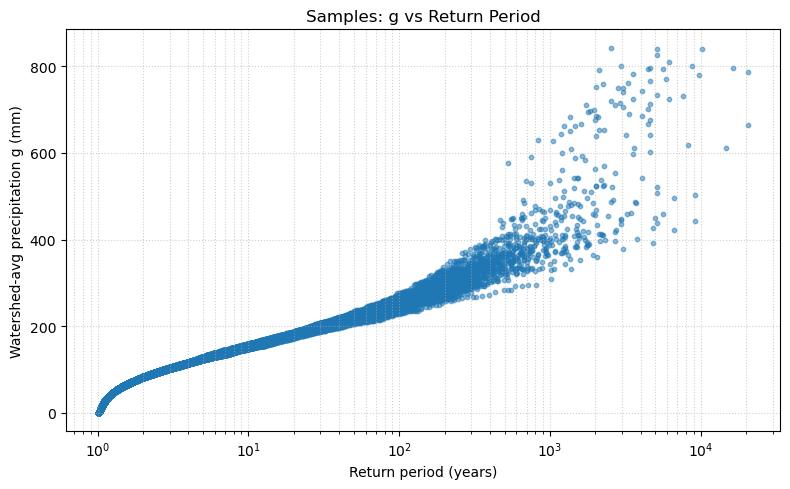

In [319]:

lam = 10.0  # storms/year, only used if we need to compute RP from excprb

df = samples.copy()
if 'RP' not in df.columns and 'excprb' in df.columns:
    exc = df['excprb'].astype(float).clip(0, 1)
    AEP = 1.0 - np.exp(-lam * exc)
    df['RP'] = 1.0 / np.maximum(AEP, 1e-12)

# keep finite, positive values
m = np.isfinite(df['RP']) & np.isfinite(df['g']) & (df['RP'] > 0) & (df['g'] > 0)
x = df.loc[m, 'RP'].to_numpy(float)
y = df.loc[m, 'g'].to_numpy(float)

# simple scatter (you can switch to a line by replacing scatter with plot)
plt.figure(figsize=(8,5))
plt.scatter(x, y, s=10, alpha=0.5)

plt.xscale('log')            # typical for return period
# plt.yscale('log')          # uncomment if you want log–log

plt.xlabel('Return period (years)')
plt.ylabel('Watershed-avg precipitation g (mm)')
plt.title('Samples: g vs Return Period')
plt.grid(True, which='both', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipykernel_8398/3813357799.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rep','g','RP']).copy()


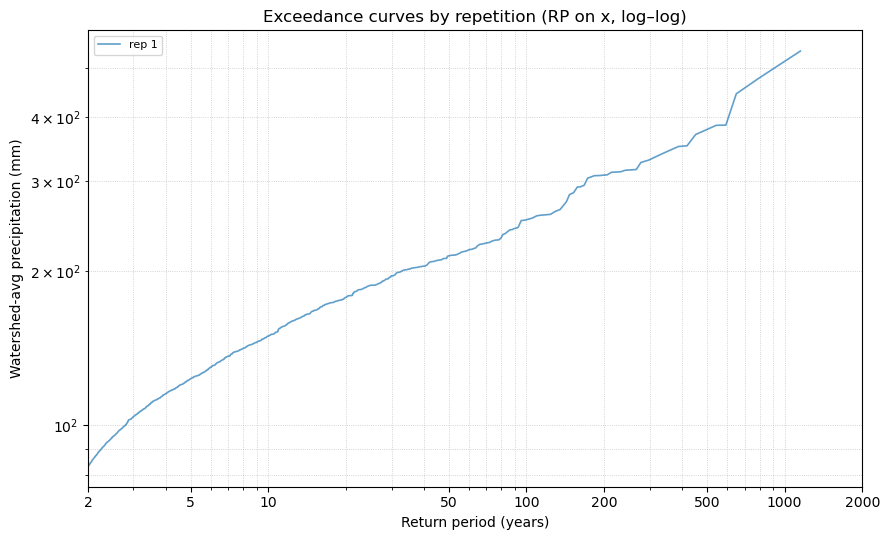

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We’ll plot g vs Return Period (RP) per rep.
# If RP isn’t in samples, we’ll compute it from excprb with Poisson rate λ=10.
lam = 10.0  # storms/year (Langbein/Poisson)

need_cols = {'rep', 'g'}
have_rp   = 'RP' in samples.columns
have_exc  = 'excprb' in samples.columns

if not (need_cols.issubset(samples.columns) and (have_rp or have_exc)):
    raise ValueError("samples must have ['rep','g'] and either 'RP' or 'excprb'.")

df = samples.loc[:, ['rep', 'g'] + (['RP'] if have_rp else []) + (['excprb'] if have_exc else [])].copy()

# Compute RP if missing (AEP = 1 - exp(-λ * excprb); RP = 1 / AEP)
if not have_rp:
    exc = df['excprb'].astype(float).clip(lower=0.0, upper=1.0)
    AEP = 1.0 - np.exp(-lam * exc)
    df['RP'] = 1.0 / np.maximum(AEP, 1e-12)

# Clean & filter for plotting
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rep','g','RP']).copy()
df = df[(df['g'] > 0) & (df['RP'] > 0)]

# Limit x to 2..2000 years
x_min, x_max = 2.0, 2000.0

fig, ax = plt.subplots(figsize=(9, 5.5))
nreps = df['rep'].nunique()
show_legend = nreps <= 12

for rep_id, g in df.groupby('rep', sort=True):
    # sort by RP (ascending), dedupe, clip to plotting window
    gg = (g.sort_values('RP')
            .drop_duplicates('RP', keep='last')
            .query('@x_min <= RP <= @x_max')
            .copy())
    if gg.shape[0] < 2:
        continue

    x = gg['RP'].to_numpy(float)
    y = gg['g'].to_numpy(float)

    # Enforce NON-DECREASING depth with RP (rarer event → larger depth)
    y_mono = np.maximum.accumulate(y)

    ax.plot(x, y_mono, linewidth=1.2, alpha=0.7, label=f"rep {rep_id}")

# Axes: log-x (RP) and log-y (depth), with 2..2000 years
ax.set_xscale("log")
ax.set_xlim(x_min, x_max)
ax.set_yscale("log")

# Nice ticks
xticks = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000])
ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])

ax.set_xlabel("Return period (years)")
ax.set_ylabel("Watershed-avg precipitation (mm)")
ax.set_title("Exceedance curves by repetition (RP on x, log–log)")

ax.grid(True, which="both", linestyle=":", linewidth=0.6, alpha=0.7)
if show_legend:
    ax.legend(ncol=2, fontsize=8)

plt.tight_layout()
plt.show()



In [320]:
import numpy as np
import pandas as pd

# Expect in `samples`: columns ['rep','RP','g']
df = samples.loc[:, ['rep','RP','g']].dropna().copy()
df = df[(df['RP'] > 0) & np.isfinite(df['RP']) & np.isfinite(df['g'])]

# Integer return-period grid
rp_years = np.arange(2, 2001, 1, dtype=float)

rows = []
for rep_id, g in df.groupby('rep', sort=True):
    # sort by RP and dedupe; keep last depth at duplicate RP
    gg = (g.sort_values('RP')
           .drop_duplicates('RP', keep='last')
           .copy())
    rp = gg['RP'].to_numpy(float)
    y  = gg['g'].to_numpy(float)

    ok = np.isfinite(rp) & np.isfinite(y) & (rp > 0)
    rp, y = rp[ok], y[ok]

    if rp.size < 2:
        y_interp = np.full_like(rp_years, np.nan, dtype=float)
    else:
        # enforce non-decreasing depth with RP (optional but recommended)
        y = np.maximum.accumulate(y)
        # **Linear** interpolation in RP space; outside-range → NaN
        y_interp = np.interp(rp_years, rp, y, left=np.nan, right=np.nan)

    rows.append(pd.DataFrame({
        'rep': rep_id,
        'year': rp_years,
        'g_interp': y_interp
    }))

per_rep_yearly = pd.concat(rows, ignore_index=True)

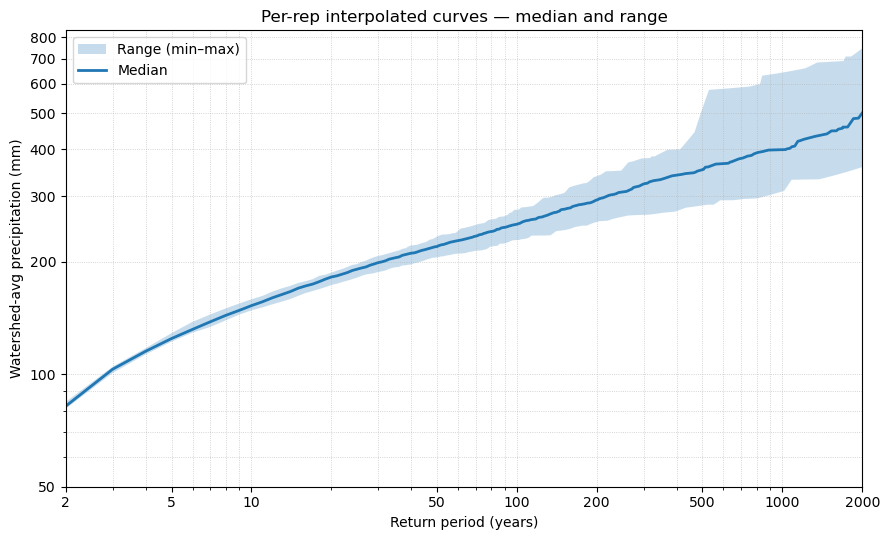

In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dfy must have ['rep','year','g_interp']
dfy = per_rep_yearly.copy()

# --- Aggregate across reps at each year using NumPy nan-reducers ---
grp = dfy.groupby('year', sort=True)['g_interp']
stats = grp.agg(
    n      = lambda s: np.isfinite(s).sum(),
    median = lambda s: np.nanmedian(s.to_numpy()),
    low    = lambda s: np.nanmin(s.to_numpy()),
    high   = lambda s: np.nanmax(s.to_numpy())
).reset_index()

# --- Require enough reps and positivity for log-y ---
nreps = dfy['rep'].nunique()
min_reps = max(3, int(np.ceil(0.5 * nreps)))
mask = (stats['n'] >= min_reps) & np.isfinite(stats['median']) & (stats['median'] > 0) \
       & np.isfinite(stats['low']) & (stats['low'] > 0) & np.isfinite(stats['high']) & (stats['high'] > 0)

years  = stats.loc[mask, 'year'].to_numpy(float)
median = stats.loc[mask, 'median'].to_numpy(float)
low    = stats.loc[mask, 'low'].to_numpy(float)
high   = stats.loc[mask, 'high'].to_numpy(float)

# Enforce non-decreasing median vs RP
median_mono = np.maximum.accumulate(median)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 5.5))
ax.fill_between(years, low, high, alpha=0.25, label='Range (min–max)')
ax.plot(years, median_mono, linewidth=2.0, label='Median')

ax.set_xlim(2, 2000)
ax.set_xscale('log')
ax.set_yscale('log')

xticks = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000])
ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])

ymax = float(np.nanmax(high)) if high.size else 100.0
ymax = max(ymax, 50.0)
ymax_rounded = int(np.ceil(ymax/100.0)*100) if ymax >= 100 else int(np.ceil(ymax))
yticks = [50] + list(range(100, ymax_rounded + 1, 100)) if ymax >= 100 else [50, ymax_rounded]
ax.set_yticks(yticks)
ax.set_yticklabels([str(int(t)) for t in yticks])

ax.set_xlabel('Return period (years)')
ax.set_ylabel('Watershed-avg precipitation (mm)')
ax.set_title('Per-rep interpolated curves — median and range')
ax.grid(True, which='both', linestyle=':', linewidth=0.6, alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()


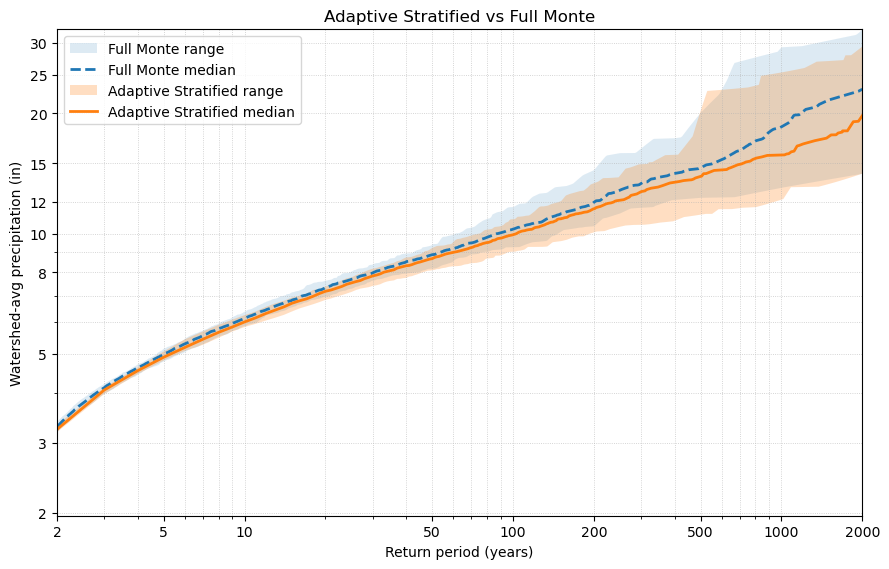

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MM_TO_IN = 1.0 / 25.4  # convert mm → inches

# =========================
# Adaptive Stratified block
# =========================
# per_rep_yearly: ['rep','year','g_interp'] where g_interp is in mm
dfy = per_rep_yearly.loc[:, ['rep','year','g_interp']].dropna().copy()
dfy = dfy[(dfy['year'] >= 2) & (dfy['year'] <= 2000) & (dfy['g_interp'] > 0) & np.isfinite(dfy['g_interp'])]

grp = dfy.groupby('year', sort=True)['g_interp']
stats = grp.agg(
    n      = lambda s: np.isfinite(s).sum(),
    median = lambda s: np.nanmedian(s.to_numpy()),
    low    = lambda s: np.nanmin(s.to_numpy()),
    high   = lambda s: np.nanmax(s.to_numpy())
).reset_index()

nreps = dfy['rep'].nunique()
min_reps = max(3, int(np.ceil(0.5 * nreps)))
maskA = (stats['n'] >= min_reps) & np.isfinite(stats['median']) & (stats['median'] > 0) \
        & np.isfinite(stats['low']) & (stats['low'] > 0) & np.isfinite(stats['high']) & (stats['high'] > 0)

years_A   = stats.loc[maskA, 'year'].to_numpy(float)
median_Ai = stats.loc[maskA, 'median'].to_numpy(float) * MM_TO_IN
low_Ai    = stats.loc[maskA, 'low'].to_numpy(float)    * MM_TO_IN
high_Ai   = stats.loc[maskA, 'high'].to_numpy(float)   * MM_TO_IN

# Enforce non-decreasing Adaptive median w.r.t. RP
median_Ai = np.maximum.accumulate(median_Ai)

# ==================
# Full Monte block
# ==================
dfM = denton_fullmonte_depths.loc[:, ['rep','return_period','precip_avg_mm']].dropna().copy()
dfM = dfM[(dfM['return_period'] > 0) & (dfM['precip_avg_mm'] > 0)
          & np.isfinite(dfM['return_period']) & np.isfinite(dfM['precip_avg_mm'])]

rp_grid = np.geomspace(2.0, 2000.0, 600)

def interp_curve_M(g: pd.DataFrame) -> np.ndarray:
    g = g.sort_values('return_period').drop_duplicates('return_period', keep='last')
    rp = g['return_period'].to_numpy(float)
    depth = g['precip_avg_mm'].to_numpy(float) * MM_TO_IN  # convert to inches
    ok = np.isfinite(rp) & np.isfinite(depth) & (rp > 0) & (depth > 0)
    rp, depth = rp[ok], depth[ok]
    if rp.size < 2:
        return np.full_like(rp_grid, np.nan, dtype=float)
    return np.interp(np.log(rp_grid), np.log(rp), depth, left=np.nan, right=np.nan)

curves_M = []
for _, g in dfM.groupby('rep', sort=True):
    curves_M.append(interp_curve_M(g))
curves_M = np.vstack(curves_M) if len(curves_M) else np.full((1, rp_grid.size), np.nan)

median_Mi = np.nanmedian(curves_M, axis=0)
low_Mi    = np.nanmin(curves_M, axis=0)
high_Mi   = np.nanmax(curves_M, axis=0)

m_spread_M = np.isfinite(low_Mi) & np.isfinite(high_Mi) & (low_Mi > 0) & (high_Mi > 0)
m_med_M    = np.isfinite(median_Mi) & (median_Mi > 0)

# ==================
# Shared plot (inches)
# ==================
fig, ax = plt.subplots(figsize=(9, 5.8))

# Full Monte (dashed)
if np.any(m_spread_M):
    ax.fill_between(rp_grid[m_spread_M], low_Mi[m_spread_M], high_Mi[m_spread_M],
                    alpha=0.15, label='Full Monte range')
if np.any(m_med_M):
    ax.plot(rp_grid[m_med_M], median_Mi[m_med_M], linewidth=2.0, linestyle='--', label='Full Monte median')

# Adaptive (solid)
if years_A.size:
    ax.fill_between(years_A, low_Ai, high_Ai, alpha=0.25, label='Adaptive Stratified range')
    ax.plot(years_A, median_Ai, linewidth=2.0, label='Adaptive Stratified median')

# Axes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2, 2000)

# Y range (inches)
candidates = []
if np.any(m_spread_M): candidates.append(np.nanmax(high_Mi[m_spread_M]))
if years_A.size:       candidates.append(np.nanmax(high_Ai))
ymax_in = float(np.nanmax(candidates)) if candidates else 4.0
ymin_in = 50.0 * MM_TO_IN  # ~2 inches, to mirror earlier 50 mm lower bound
ymax_in = max(ymax_in, ymin_in*1.1)
ax.set_ylim(ymin_in, ymax_in)
ax.autoscale(enable=False, axis='y')

# Ticks
xticks = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000], dtype=float)
ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])

# Nice inch ticks for log-y
inch_candidates = np.array([1, 2, 3, 5, 8, 10, 12, 15, 20, 25, 30, 40, 50], dtype=float)
yticks = inch_candidates[(inch_candidates >= ymin_in) & (inch_candidates <= ymax_in)]
if yticks.size == 0: yticks = np.array([ymin_in, ymax_in])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{t:g}" for t in yticks])

ax.set_xlabel('Return period (years)')
ax.set_ylabel('Watershed-avg precipitation (in)')
ax.set_title('Adaptive Stratified vs Full Monte')
ax.grid(True, which='both', linestyle=':', linewidth=0.6, alpha=0.7)
ax.legend()
fig.tight_layout()
plt.show()



In [325]:
import numpy as np
import pandas as pd

MM_TO_IN = 1.0 / 25.4

# --- Adaptive (per_rep_yearly has integer years; g_interp in mm) ---
dfA = per_rep_yearly.loc[:, ['rep','year','g_interp']].dropna().copy()
dfA = dfA[np.isfinite(dfA['g_interp']) & (dfA['g_interp'] > 0)]
A2000_mm = np.nanmedian(dfA.loc[np.isclose(dfA['year'], 2000.0), 'g_interp'].to_numpy())
A2000_in = A2000_mm * MM_TO_IN

# --- Full Monte (interpolate each rep to RP=2000 in log-RP space; precip_avg_mm in mm) ---
def interp_at_2000(g: pd.DataFrame) -> float:
    g = (g[['return_period','precip_avg_mm']].dropna()
           .query('return_period > 0 and precip_avg_mm > 0')
           .sort_values('return_period')
           .drop_duplicates('return_period', keep='last'))
    rp = g['return_period'].to_numpy(float)
    depth = g['precip_avg_mm'].to_numpy(float)
    if rp.size < 2:
        return np.nan
    return float(np.interp(np.log(2000.0), np.log(rp), depth, left=np.nan, right=np.nan))

vals_2000_mm = [interp_at_2000(g) for _, g in denton_fullmonte_depths.groupby('rep', sort=True)]
M2000_mm = np.nanmedian(np.array(vals_2000_mm, dtype=float))
M2000_in = M2000_mm * MM_TO_IN

# --- Difference ---
diff_in = A2000_in - M2000_in

print(f"Adaptive median @2000-yr:   {A2000_in:.3f} in")
print(f"Full Monte median @2000-yr: {M2000_in:.3f} in")
print(f"Difference (Adaptive - Full Monte): {diff_in:+.3f} in")

Adaptive median @2000-yr:   19.725 in
Full Monte median @2000-yr: 22.979 in
Difference (Adaptive - Full Monte): -3.254 in


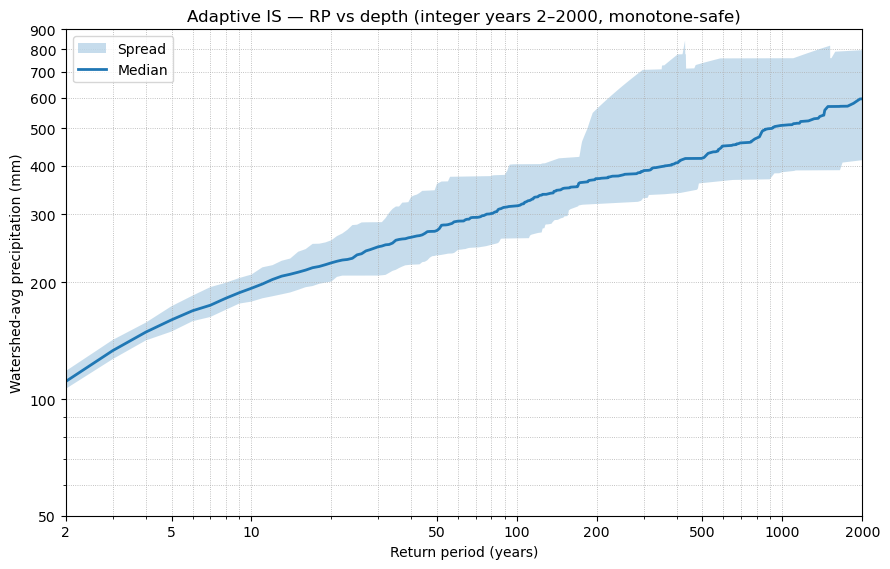

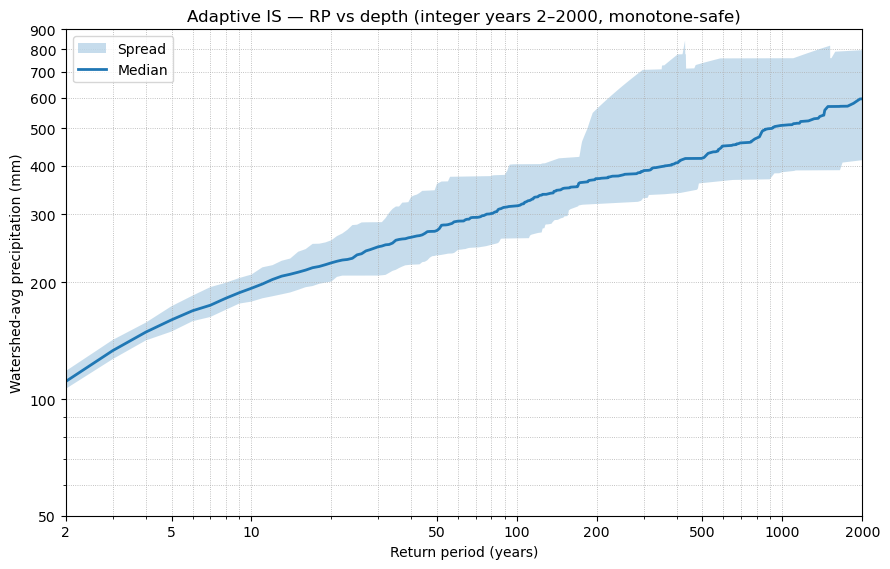

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Clean input (needs columns: ['rep','RP','g']) ---
df = samples.loc[:, ['rep', 'RP', 'g']].dropna().copy()
df = df[(df['RP'] > 0) & (df['g'] > 0) & np.isfinite(df['RP']) & np.isfinite(df['g'])]

# --- Integer RP grid: 2..2000 (inclusive) ---
rp_years = np.arange(2, 2001, 1, dtype=float)

def interp_rep_monotone(group: pd.DataFrame) -> np.ndarray:
    """Sort by RP, enforce non-decreasing depth, then interpolate onto integer years (log-RP space)."""
    g = (group.sort_values('RP')
               .drop_duplicates('RP', keep='last')
               .copy())
    rp = g['RP'].to_numpy(float)
    depth = g['g'].to_numpy(float)

    ok = np.isfinite(rp) & np.isfinite(depth) & (rp > 0) & (depth >= 0)
    rp, depth = rp[ok], depth[ok]
    if rp.size < 2:
        return np.full_like(rp_years, np.nan, dtype=float)

    # Enforce monotone non-decreasing depth with RP
    depth_mono = np.maximum.accumulate(depth)

    # Interpolate in log-RP space; outside becomes NaN
    y = np.interp(np.log(rp_years), np.log(rp), depth_mono, left=np.nan, right=np.nan)
    return y

# --- Build per-rep curves on the common integer grid ---
curves = [interp_rep_monotone(g) for _, g in df.groupby('rep', sort=True)]
curves = np.vstack(curves) if len(curves) else np.full((1, rp_years.size), np.nan)

# --- Compute stats only where enough reps contribute ---
counts = np.sum(np.isfinite(curves), axis=0)
min_reps = max(3, int(np.ceil(0.5 * curves.shape[0])))  # require at least half (or 3) reps at a point
mask = counts >= min_reps

median = np.nanmedian(np.where(mask, curves, np.nan), axis=0)
low    = np.nanmin(np.where(mask, curves, np.nan), axis=0)
high   = np.nanmax(np.where(mask, curves, np.nan), axis=0)

# Enforce monotone on the median too (non-decreasing with RP)
median_mono = np.maximum.accumulate(median)

# --- Axes ticks & ranges ---
xticks = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000])
ymax = float(np.nanmax(high[mask])) if np.any(mask) else (float(np.nanmax(median_mono[np.isfinite(median_mono)])) if np.any(np.isfinite(median_mono)) else 100.0)
ymax = max(ymax, 50.0)
ymax_rounded = int(np.ceil(ymax/100.0)*100) if ymax >= 100 else int(np.ceil(ymax))
yticks = [50] + list(range(100, ymax_rounded + 1, 100)) if ymax >= 100 else [50, ymax_rounded]

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 5.8))

# Spread band & monotone median (only where mask is True)
if np.any(mask):
    ax.fill_between(rp_years[mask], low[mask], high[mask], alpha=0.25, label='Spread')
    ax.plot(rp_years[mask], median_mono[mask], linewidth=2.0, label='Median')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2, 2000)
ax.set_ylim(50, ymax)
ax.autoscale(enable=False, axis='y')

ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels([str(int(t)) for t in yticks])

ax.set_xlabel('Return period (years)')
ax.set_ylabel('Watershed-avg precipitation (mm)')
ax.set_title('Adaptive IS — RP vs depth (integer years 2–2000, monotone-safe)')
ax.grid(True, which='both', linestyle=':', linewidth=0.6)
ax.legend()
fig.tight_layout()
plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Clean input (needs columns: ['rep','RP','g']) ---
df = samples.loc[:, ['rep', 'RP', 'g']].dropna().copy()
df = df[(df['RP'] > 0) & (df['g'] > 0) & np.isfinite(df['RP']) & np.isfinite(df['g'])]

# --- Integer RP grid: 2..2000 (inclusive) ---
rp_years = np.arange(2, 2001, 1, dtype=float)

def interp_rep_monotone(group: pd.DataFrame) -> np.ndarray:
    """Sort by RP, enforce non-decreasing depth, then interpolate onto integer years (log-RP space)."""
    g = (group.sort_values('RP')
               .drop_duplicates('RP', keep='last')
               .copy())
    rp = g['RP'].to_numpy(float)
    depth = g['g'].to_numpy(float)

    ok = np.isfinite(rp) & np.isfinite(depth) & (rp > 0) & (depth >= 0)
    rp, depth = rp[ok], depth[ok]
    if rp.size < 2:
        return np.full_like(rp_years, np.nan, dtype=float)

    # Enforce monotone non-decreasing depth with RP
    depth_mono = np.maximum.accumulate(depth)

    # Interpolate in log-RP space; outside becomes NaN
    y = np.interp(np.log(rp_years), np.log(rp), depth_mono, left=np.nan, right=np.nan)
    return y

# --- Build per-rep curves on the common integer grid ---
curves = [interp_rep_monotone(g) for _, g in df.groupby('rep', sort=True)]
curves = np.vstack(curves) if len(curves) else np.full((1, rp_years.size), np.nan)

# --- Compute stats only where enough reps contribute ---
counts = np.sum(np.isfinite(curves), axis=0)
min_reps = max(3, int(np.ceil(0.5 * curves.shape[0])))  # require at least half (or 3) reps at a point
mask = counts >= min_reps

median = np.nanmedian(np.where(mask, curves, np.nan), axis=0)
low    = np.nanmin(np.where(mask, curves, np.nan), axis=0)
high   = np.nanmax(np.where(mask, curves, np.nan), axis=0)

# Enforce monotone on the median too (non-decreasing with RP)
median_mono = np.maximum.accumulate(median)

# --- Axes ticks & ranges ---
xticks = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000])
ymax = float(np.nanmax(high[mask])) if np.any(mask) else (float(np.nanmax(median_mono[np.isfinite(median_mono)])) if np.any(np.isfinite(median_mono)) else 100.0)
ymax = max(ymax, 50.0)
ymax_rounded = int(np.ceil(ymax/100.0)*100) if ymax >= 100 else int(np.ceil(ymax))
yticks = [50] + list(range(100, ymax_rounded + 1, 100)) if ymax >= 100 else [50, ymax_rounded]

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 5.8))

# Spread band & monotone median (only where mask is True)
if np.any(mask):
    ax.fill_between(rp_years[mask], low[mask], high[mask], alpha=0.25, label='Spread')
    ax.plot(rp_years[mask], median_mono[mask], linewidth=2.0, label='Median')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(2, 2000)
ax.set_ylim(50, ymax)
ax.autoscale(enable=False, axis='y')

ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels([str(int(t)) for t in yticks])

ax.set_xlabel('Return period (years)')
ax.set_ylabel('Watershed-avg precipitation (mm)')
ax.set_title('Adaptive IS — RP vs depth (integer years 2–2000, monotone-safe)')
ax.grid(True, which='both', linestyle=':', linewidth=0.6)
ax.legend()
fig.tight_layout()
plt.show()


/tmp/ipykernel_8398/3293039324.py:40: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(np.where(mask, curves, np.nan), axis=0)


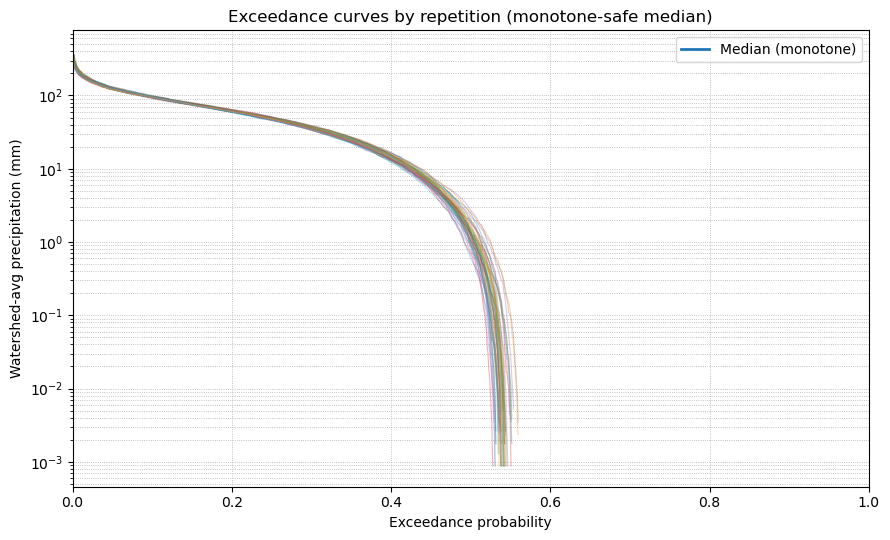

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expect: samples with columns ['rep','excprb','g']
df = samples.loc[:, ['rep','excprb','g']].dropna().copy()
df = df[np.isfinite(df['excprb']) & np.isfinite(df['g']) & (df['g'] > 0)]

# 1) Common excprb grid (avoid exact 0/1 to be safe on log transforms later if any)
x_grid = np.linspace(1e-6, 1-1e-6, 1000)

def interp_rep_monotone(grep: pd.DataFrame) -> np.ndarray:
    """Sort by excprb, dedupe, enforce non-increasing g, interp to x_grid."""
    g2 = (grep.sort_values('excprb')
               .drop_duplicates('excprb', keep='last')
               .copy())
    x = g2['excprb'].to_numpy(float)
    y = g2['g'].to_numpy(float)

    if x.size < 2:
        return np.full_like(x_grid, np.nan, dtype=float)

    # Enforce non-increasing depth as excprb increases:
    # y_mono[i] >= y_mono[i+1]; do a right-to-left cumulative max
    y_mono = np.maximum.accumulate(y[::-1])[::-1]

    # Interpolate onto common grid; leave outside-range as NaN
    y_interp = np.interp(x_grid, x, y_mono, left=np.nan, right=np.nan)
    return y_interp

# 2) Build per-rep curves on the common grid
curves = [interp_rep_monotone(g) for _, g in df.groupby('rep', sort=True)]
curves = np.vstack(curves) if len(curves) else np.full((1, x_grid.size), np.nan)

# 3) Compute median only where enough reps contribute
counts = np.sum(np.isfinite(curves), axis=0)
min_reps = max(3, int(np.ceil(0.5 * curves.shape[0])))  # require at least half (or 3)
mask = counts >= min_reps

median = np.nanmedian(np.where(mask, curves, np.nan), axis=0)

# 4) Enforce non-increasing on the median too (safety against membership changes)
median_mono = np.maximum.accumulate(median[::-1])[::-1]

# 5) Plot all reps (thin) + monotone median (thick), log-y
fig, ax = plt.subplots(figsize=(9, 5.5))

for row in curves:
    ax.plot(x_grid, row, linewidth=0.8, alpha=0.35)

ax.plot(x_grid[mask], median_mono[mask], linewidth=2.0, label='Median (monotone)')

ax.set_xlim(0, 1)
ax.set_yscale('log')
ax.set_xlabel('Exceedance probability')
ax.set_ylabel('Watershed-avg precipitation (mm)')
ax.set_title('Exceedance curves by repetition (monotone-safe median)')
ax.grid(True, which='both', linestyle=':', linewidth=0.6)
ax.legend()
plt.tight_layout()
plt.show()


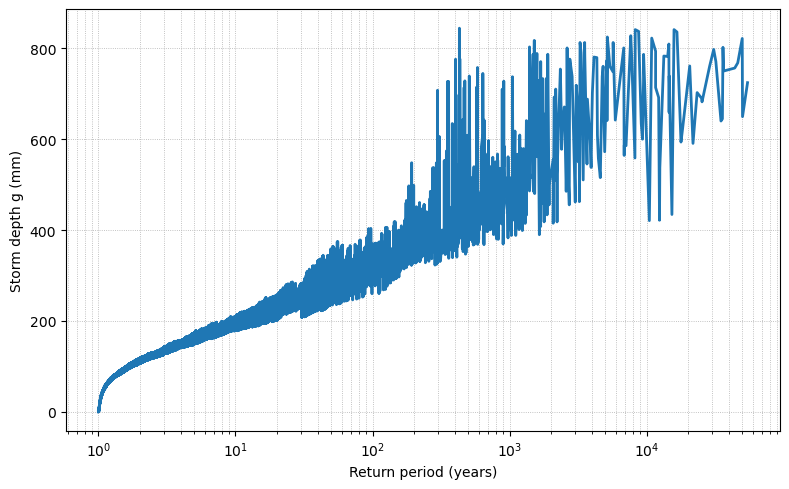

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use the table you just built ('df'); otherwise fall back to `samples`
src = df[['RP','g']].dropna().copy() if 'df' in locals() else samples[['RP','g']].dropna().copy()

# Keep finite/positive RPs; sort by RP (x-axis)
src = src[np.isfinite(src['RP']) & (src['RP'] > 0) & np.isfinite(src['g'])].copy()
src = src.sort_values('RP', ascending=True)

# Plot: g on Y, RP on X (log-x), simple line (no step)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(src['RP'].values, src['g'].values, linewidth=2.0)

ax.set_xscale('log')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Storm depth g (mm)')
ax.grid(True, which='both', linestyle=':', linewidth=0.6)
fig.tight_layout()
plt.show()

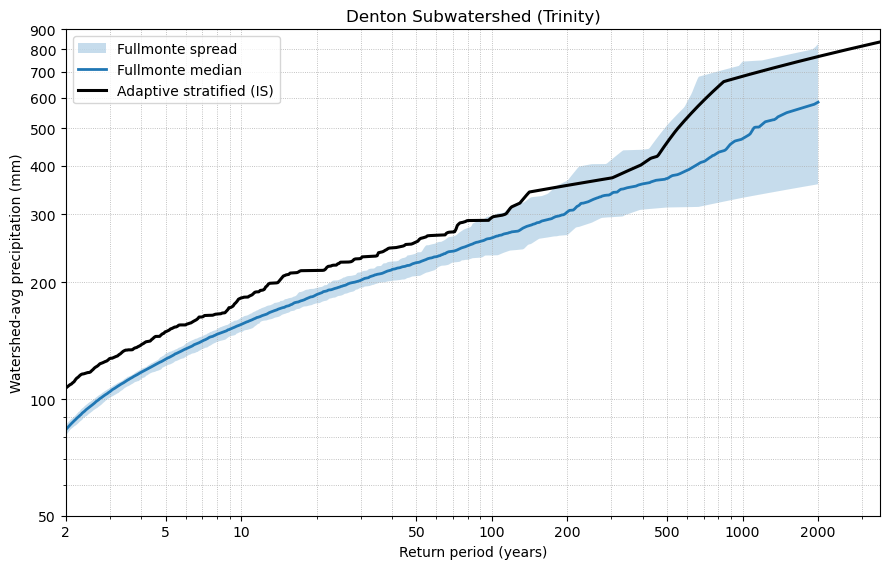

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Fullmonte spread (your code, just wrapped in vars) ----------
df_fm = denton_fullmonte_depths[['rep','return_period','precip_avg_mm']].dropna().copy()

rp_min = 2.0
rp_max = float(np.nanmax(df_fm['return_period']))
rp_max = max(rp_min, rp_max)
rp_grid = np.geomspace(rp_min, rp_max, 600)

def interp_curve(group: pd.DataFrame) -> np.ndarray:
    g = (group.sort_values('return_period')
               .drop_duplicates('return_period', keep='last'))
    rp = g['return_period'].to_numpy(float)
    depth = g['precip_avg_mm'].to_numpy(float)
    ok = np.isfinite(rp) & np.isfinite(depth) & (rp > 0) & (depth >= 0)
    rp, depth = rp[ok], depth[ok]
    if rp.size < 2:
        return np.full_like(rp_grid, np.nan, dtype=float)
    return np.interp(np.log(rp_grid), np.log(rp), depth, left=np.nan, right=np.nan)

curves = np.vstack([interp_curve(g) for _, g in df_fm.groupby('rep')])
median = np.nanmedian(curves, axis=0)
low    = np.nanmin(curves, axis=0)
high   = np.nanmax(curves, axis=0)

m_spread = np.isfinite(low) & np.isfinite(high) & (low > 0) & (high > 0)
m_med    = np.isfinite(median) & (median > 0)

xticks_all = np.array([2, 5, 10, 50, 100, 200, 500, 1000, 2000])
xticks = xticks_all[(xticks_all >= rp_min) & (xticks_all <= rp_max)]

ymax = float(np.nanmax(high[m_spread])) if np.any(m_spread) else 100.0
ymax = max(ymax, 50.0)
ymax_rounded = int(np.ceil(ymax/100.0)*100) if ymax >= 100 else int(np.ceil(ymax))
yticks = [50] + list(range(100, ymax_rounded + 1, 100)) if ymax >= 100 else [50, ymax_rounded]

fig, ax = plt.subplots(figsize=(9, 5.8))
ax.fill_between(rp_grid[m_spread], low[m_spread], high[m_spread], alpha=0.25, label='Fullmonte spread')
ax.plot(rp_grid[m_med], median[m_med], linewidth=2.0, label='Fullmonte median')

# ---------- Overlay: your adaptive IS curve ----------
# take your samples table with RP and g
df_is = samples[['RP','g']].dropna().copy()
df_is = df_is[np.isfinite(df_is['RP']) & (df_is['RP'] > 0) & np.isfinite(df_is['g'])]

# optional: extend rp_max if your curve goes further
if df_is['RP'].max() > rp_max:
    rp_max = float(df_is['RP'].max())
    rp_grid = np.geomspace(rp_min, rp_max, 600)

# interpolate your curve in log-RP space to make a smooth line
df_is = df_is.sort_values('RP').drop_duplicates('RP', keep='last')
rp_my = df_is['RP'].to_numpy(float)
g_my  = df_is['g'].to_numpy(float)
g_interp = np.interp(np.log(rp_grid), np.log(rp_my), g_my, left=np.nan, right=np.nan)

ax.plot(rp_grid, g_interp, linewidth=2.2, color='k', label='Adaptive stratified (IS)', zorder=10)

# ---------- Axes & cosmetics ----------
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(rp_min, rp_max)
ax.set_ylim(50, ymax)
ax.autoscale(enable=False, axis='y')

ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels([str(int(t)) for t in yticks])

ax.set_xlabel('Return period (years)')
ax.set_ylabel('Watershed-avg precipitation (mm)')
ax.set_title('Denton Subwatershed (Trinity)')
ax.grid(True, which='both', linestyle=':', linewidth=0.6)
ax.legend()
fig.tight_layout()
plt.show()


/tmp/ipykernel_8398/2548052908.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper right")


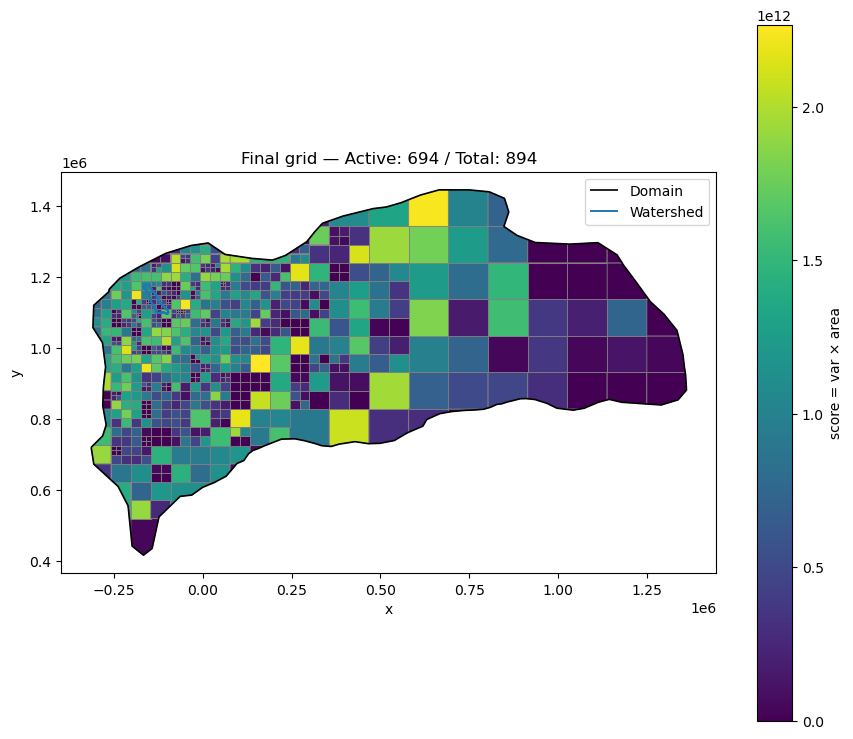

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1) Grab the last snapshot (or use sampler.leaves if you didn't store snapshots)
final_gdf = sampler.grids_by_iter[-1].copy()   # GeoDataFrame with polygons + columns

# Optional: a useful color metric
final_gdf["score"] = final_gdf["var"].fillna(0.0) * final_gdf["area_in_domain"]

# 2) Split active/inactive
active_gdf   = final_gdf[final_gdf["active"]].copy()
inactive_gdf = final_gdf[~final_gdf["active"]].copy()

# 3) Plot
fig, ax = plt.subplots(figsize=(9,9))

# Domain & watershed outlines
sampler.domain_gdf.boundary.plot(ax=ax, color="black", linewidth=1.2, label="Domain")
sampler.watershed_gdf.boundary.plot(ax=ax, color="tab:blue", linewidth=1.4, label="Watershed")

# Inactive cells (light outlines)
if not inactive_gdf.empty:
    inactive_gdf.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.6, label="Inactive")

# Active cells colored by score (or change 'score' → 'var'/'mean'/'n'/'alloc')
if not active_gdf.empty:
    active_gdf.plot(
        ax=ax, column="score", cmap="viridis",
        edgecolor="gray", linewidth=0.6,
        legend=True, legend_kwds={"label": "score = var × area", "shrink": 0.8}
    )

# Cosmetics
ax.set_aspect("equal")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title(f"Final grid — Active: {int(active_gdf.shape[0])} / Total: {int(final_gdf.shape[0])}")
ax.grid(False) 
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [177]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# --- Final grid GeoDataFrame ---
if len(sampler.grids_by_iter) > 0:
    final_gdf = sampler.grids_by_iter[-1].copy()
else:
    # build from current leaves if no snapshots were stored
    polys = [box(r.x_min, r.y_min, r.x_max, r.y_max) for _, r in sampler.leaves.iterrows()]
    final_gdf = gpd.GeoDataFrame(sampler.leaves.copy(), geometry=polys, crs=sampler.domain_gdf.crs)
    final_gdf["geometry"] = final_gdf.geometry.intersection(sampler.domain_geom)
    final_gdf = final_gdf[~final_gdf.geometry.is_empty & final_gdf.geometry.notnull()].copy()

# --- All samples as a GeoDataFrame ---
pts_df = sampler.samples.loc[:, ["x", "y"]].dropna()
gdf_pts = gpd.GeoDataFrame(
    pts_df,
    geometry=gpd.points_from_xy(pts_df["x"], pts_df["y"]),
    crs=sampler.domain_gdf.crs
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 9))

# Domain & watershed (black outlines)
sampler.domain_gdf.boundary.plot(ax=ax, color="black", linewidth=1.2)
sampler.watershed_gdf.boundary.plot(ax=ax, color="black", linewidth=1.2, linestyle="--")

# Final grid as thin black outlines
final_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)

# All sampled points as small black dots
if not gdf_pts.empty:
    ax.scatter(gdf_pts.geometry.x, gdf_pts.geometry.y, s=6, c="black", alpha=0.7)

# Clean axes (no grid, no ticks, no spines)
ax.set_aspect("equal")
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Final grid and sampled points", pad=10)
plt.tight_layout()
plt.show()


AttributeError: 'AdaptiveStratifiedSampler' object has no attribute 'grids_by_iter'

In [81]:
sampler.grids_by_rep

[]

In [80]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import matplotlib.patheffects as pe

# --- Final grid GeoDataFrame (clipped to domain) ---
if len(sampler.grids_by_iter) > 0:
    final_gdf = sampler.grids_by_iter[-1].copy()
else:
    polys = [box(r.x_min, r.y_min, r.x_max, r.y_max) for _, r in sampler.leaves.iterrows()]
    final_gdf = gpd.GeoDataFrame(sampler.leaves.copy(), geometry=polys, crs=sampler.domain_gdf.crs)
    final_gdf["geometry"] = final_gdf.geometry.intersection(sampler.domain_geom)
    final_gdf = final_gdf[~final_gdf.geometry.is_empty & final_gdf.geometry.notnull()].copy()

# --- Pick one repetition of samples ---
rep_id = 0  # <-- change to whichever rep you want
pts_df = sampler.samples.loc[sampler.samples["rep"] == rep_id, ["x", "y"]].dropna()

gdf_pts = gpd.GeoDataFrame(
    pts_df,
    geometry=gpd.points_from_xy(pts_df["x"], pts_df["y"]),
    crs=sampler.domain_gdf.crs,
)

fig, ax = plt.subplots(figsize=(9, 9))

# 1) Domain outline
sampler.domain_gdf.boundary.plot(ax=ax, color="black", linewidth=1.0, zorder=1)

# 2) Final grid
final_gdf.plot(ax=ax, facecolor="0.85", alpha=0.35, edgecolor="black", linewidth=0.5, zorder=2)

# 3) Points for selected rep only
if not gdf_pts.empty:
    ax.scatter(
        gdf_pts.geometry.x, gdf_pts.geometry.y,
        s=8, c="red", alpha=0.6, linewidths=0, zorder=3, label=f"Samples rep {rep_id}"
    )

# 4) Watershed outline (with halo)
ws = sampler.watershed_gdf
line = ws.boundary.plot(ax=ax, color="black", linewidth=2.2, zorder=5)
for artist in line.collections:
    artist.set_path_effects([pe.Stroke(linewidth=4.0, foreground="white"), pe.Normal()])

# Clean axes
ax.set_aspect("equal")
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title(f"Final grid and sampled points (rep {rep_id})", pad=10)
ax.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.show()


AttributeError: 'AdaptiveStratifiedSampler' object has no attribute 'grids_by_iter'

In [92]:
sampler.samples

,sample_id,rep,iter,leaf_id,x,y,storm_path,g,w_uniform
0,0,1,1,0,-206200.011556,5.138732e+05,20200826_72hr_st2_r093,4.243860,0.136802
1,1,1,1,1,-208151.272807,6.158483e+05,20030505_72hr_st1_r073,0.000000,1.235513
2,2,1,1,1,-241520.474200,6.168718e+05,20200902_72hr_st3_r088,0.000000,1.235513
3,3,1,1,2,-283143.115701,7.227224e+05,20090331_72hr_st1_r169,0.000000,41.537859
4,4,1,1,2,-268866.399472,7.016608e+05,20190714_72hr_st2_r127,153.731578,41.537859
...,...,...,...,...,...,...,...,...,...
999945,999945,50,40,560,144836.422937,1.134774e+06,19890516_72hr_st1_r028,120.450005,0.306668
999946,999946,50,40,567,-291322.513717,1.030681e+06,20151030_72hr_st1_r173,140.308777,0.158597
999947,999947,50,40,572,-94647.835230,1.007159e+06,19831202_72hr_st1_r051,117.994735,0.391002
999948,999948,50,40,572,-97682.359736,9.971310e+05,20200204_72hr_st1_r157,50.842982,0.391002


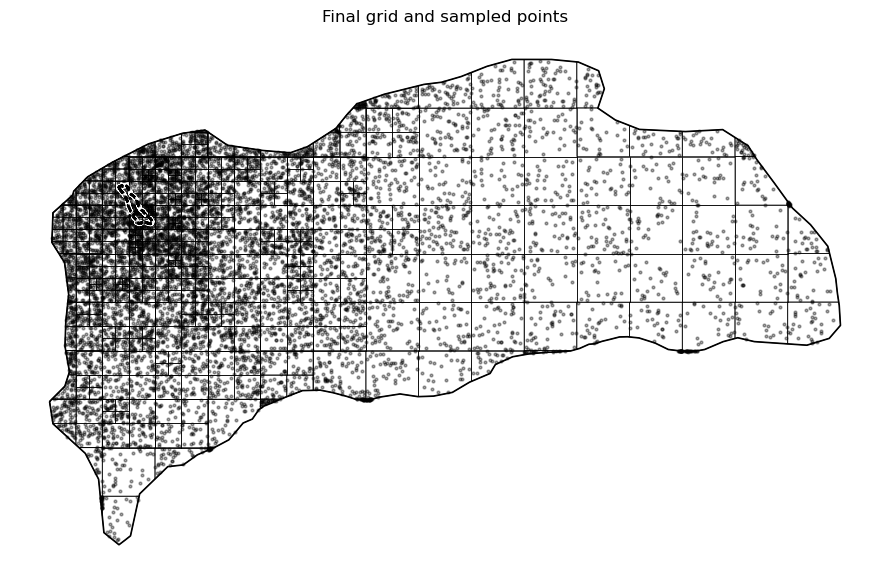

In [327]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# --- Final grid GeoDataFrame ---
if len(sampler.grids_by_rep[1]) > 0:
    final_gdf = sampler.grids_by_rep[1][-1].copy()
else:
    # build from current leaves if no snapshots were stored
    polys = [box(r.x_min, r.y_min, r.x_max, r.y_max) for _, r in sampler.leaves.iterrows()]
    final_gdf = gpd.GeoDataFrame(sampler.leaves.copy(), geometry=polys, crs=sampler.domain_gdf.crs)
    final_gdf["geometry"] = final_gdf.geometry.intersection(sampler.domain_geom)
    final_gdf = final_gdf[~final_gdf.geometry.is_empty & final_gdf.geometry.notnull()].copy()

# --- All samples as a GeoDataFrame ---
pts_df = sampler.samples.loc[sampler.samples["rep"].isin([2]), ["x","y"]].dropna()
gdf_pts = gpd.GeoDataFrame(
    pts_df,
    geometry=gpd.points_from_xy(pts_df["x"], pts_df["y"]),
    crs=sampler.domain_gdf.crs
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 9))

# Domain & watershed (black outlines)
sampler.domain_gdf.boundary.plot(ax=ax, color="black", linewidth=1.2)
sampler.watershed_gdf.boundary.plot(ax=ax, color="black", linewidth=1.2, linestyle="--")

# Final grid as thin black outlines
final_gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)

# All sampled points as small, semi-transparent black dots
if not gdf_pts.empty:
    ax.scatter(gdf_pts.geometry.x, gdf_pts.geometry.y, s=4, c="black", alpha=0.35)

# Overlay watershed AGAIN so it pops on top (white halo + black dashed)
sampler.watershed_gdf.boundary.plot(ax=ax, color="white", linewidth=3.2, linestyle="--", zorder=5)
sampler.watershed_gdf.boundary.plot(ax=ax, color="black", linewidth=1.8, linestyle="--", zorder=6)

# Clean axes (no grid, no ticks, no spines)
ax.set_aspect("equal")
ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Final grid and sampled points", pad=10)
plt.tight_layout()
plt.show()


In [25]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

grids = sampler.grids_by_iter            # list of GeoDataFrames (one per iter)
out_gif = "grid_evolution.gif"

fig, ax = plt.subplots(figsize=(8, 8))

def draw(i):
    ax.clear()
    # domain + grid for iteration i
    sampler.domain_gdf.boundary.plot(ax=ax, color="black", linewidth=1.0, zorder=1)
    grids[i].boundary.plot(ax=ax, color="black", linewidth=0.5, zorder=2)
    # watershed on top (white halo + black dashed to pop)
    sampler.watershed_gdf.boundary.plot(ax=ax, color="white", linewidth=3.0, linestyle="--", zorder=3)
    sampler.watershed_gdf.boundary.plot(ax=ax, color="black", linewidth=1.6, linestyle="--", zorder=4)

    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)
    it = int(grids[i]["iter"].iloc[0]) if "iter" in grids[i].columns else i+1
    ax.set_title(f"Grid evolution — iter {it}")

ani = FuncAnimation(fig, draw, frames=len(grids), interval=300, blit=False)
ani.save(out_gif, writer=PillowWriter(fps=2))
plt.close(fig)

print(f"Saved: {out_gif}")


Saved: grid_evolution.gif
